In [4]:
libraries = c("dplyr","magrittr","tidyr","ggplot2","readxl","RColorBrewer","zoo",
              "readxl","writexl","gridExtra","MASS","ggpubr", "mixdist","lubridate")
for(x in libraries) { library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE) }

'%&%' = function(x,y)paste0(x,y)

theme_set(theme_bw())
version$version.string
    
options(scipen=10000)
    
#### The code is written by Sung-mok Jung

[1] "R version 4.1.1 (2021-08-10)"

# 4X4 Contact matrix

In [3]:
#### adjusted matrix
read_excel("../data/modified_matrix.xlsx", sheet="modified") -> adj_contact
adj_contact %<>% rename('60s+' = '60+')
(as.matrix(adj_contact[,-1]) -> adj_contact)

New names:
* `` -> ...1



0-19,20-39,40-59,60s+
9.8792692,3.255860,4.247270,0.9407732
2.1235897,7.661928,5.041589,1.0089279
2.2603724,4.113701,6.046642,1.0535665
0.7038058,1.157239,1.481016,1.4421330


#  Data for reconstruction of NGM

In [5]:
options(warn=-1) 
read_excel("../data/db210930.xlsx") -> master_df
master_df %<>% rename(reported=신고일, diagnosis=진단일, onset=발병일, published=보도일,
                      variant=변이, age=연령, route=감염경로)

as.Date(master_df$reported) -> master_df$reported
as.Date(master_df$diagnosis) -> master_df$diagnosis
as.Date(master_df$onset) -> master_df$onset
as.Date(master_df$published) -> master_df$published


master_df %<>%
mutate(age_group = case_when(age < 20 ~ "1",
                             age >= 20 & age < 40 ~ "2",
                             age >= 40 & age < 60 ~ "3",
                             age >= 60 ~ "4"))

options(warn=0)

master_df %>% filter(route==c("국내")) -> master_dom_df #### domsetic cases
master_df %>% filter(route==c("국외")) -> master_imp_df #### imported cases

(Final_date <- as.Date(max(master_df$published)+1))

[1] "2021-09-28"

### Estimation of reporting delay

In [6]:
master_df %>% filter(!is.na(onset)) %>% 
mutate(dist= as.numeric(published-onset)) %>% filter(dist>=0) -> master_delay

master_delay %>% dplyr::select(onset, dist) %>% filter(dist <= 30)-> dt.delay1
master_delay %>% mutate(distt = as.numeric(Final_date-onset)) %>% 
dplyr::select(onset, distt) %>% na.omit() -> dt.delay2

dt.delay1$dist <- as.numeric(dt.delay1$dist)
dt.delay2$distt <- as.numeric(dt.delay2$distt)
dt.delay1$dist[dt.delay1$dist<=0] <- 0.5

delay.llk <- function(param){
       
a0 = param[1]; b0 = param[2]; 
total.lik.gamma_n <- rep(0,length(dt.delay1))
    
    return(-sum(log((pweibull((dt.delay1$dist+0.5), shape = a0, scale = b0)-
                     pweibull(dt.delay1$dist-0.5, shape = a0, scale = b0))/
                   (pweibull(dt.delay2$distt, shape = a0, scale = b0)))))}

param00 =  c(2, 10)
options(warn=-1)
opt_delay <- optim(param00, fn=delay.llk, method='BFGS', control = list(maxit=100000, trace=0))
param <- opt_delay$par
options(warn=0)

library(mixdist)
weibullparinv(param[1], param[2], loc = 0)

mu,sigma,loc
<dbl>,<dbl>,<dbl>
3.579073,2.422432,0


### Daily confirmed cases in Korea

In [7]:
as.numeric(Final_date-1-min(master_df$published)) -> time.diff
ttime <- as.data.frame(c(0:time.diff))
colnames(ttime) <- c('t')
ttime %<>% mutate(published = min(master_df$published)+t)

In [8]:
master_df %>% filter(age_group==c("1")) %>% group_by(published) %>% count() %>% as.data.frame() -> data_1
merge(ttime, data_1, by='published', all.x=TRUE) -> data_1
data_1[is.na(data_1)] <- 0

master_df %>% filter(age_group==c("2")) %>% group_by(published) %>% count() %>% as.data.frame() -> data_2
merge(ttime, data_2, by='published', all.x=TRUE) -> data_2
data_2[is.na(data_2)] <- 0

master_df %>% filter(age_group==c("3")) %>% group_by(published) %>% count() %>% as.data.frame() -> data_3
merge(ttime, data_3, by='published', all.x=TRUE) -> data_3
data_3[is.na(data_3)] <- 0

master_df %>% filter(age_group==c("4")) %>% group_by(published) %>% count() %>% as.data.frame() -> data_4
merge(ttime, data_4, by='published', all.x=TRUE) -> data_4
data_4[is.na(data_4)] <- 0

[1] 303553

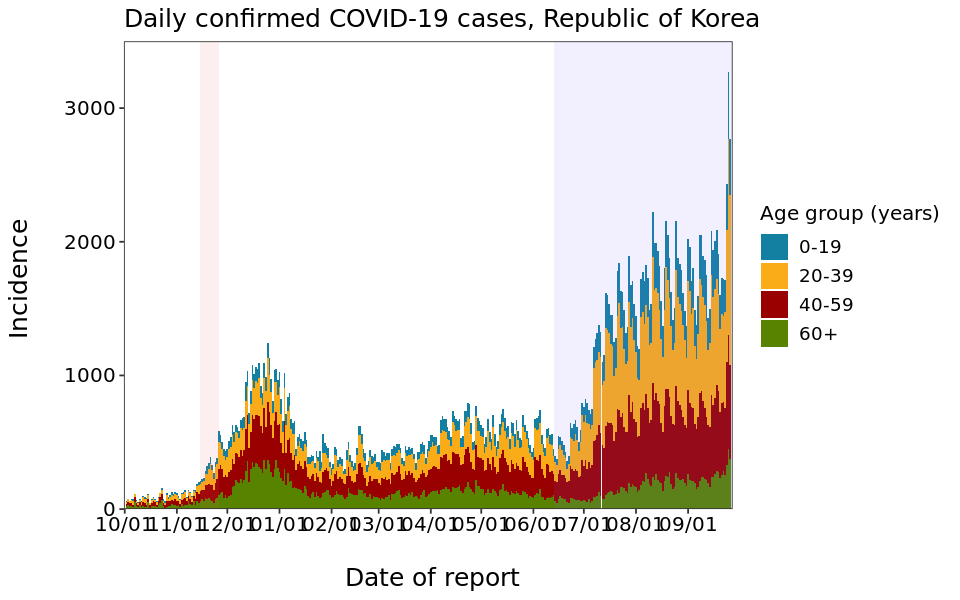

In [9]:
data_1 %<>% arrange(published) %>% mutate(age_group=c("0-19"))
data_2 %<>% arrange(published) %>% mutate(age_group=c("20-39"))
data_3 %<>% arrange(published) %>% mutate(age_group=c("40-59"))
data_4 %<>% arrange(published) %>% mutate(age_group=c("60+"))

rbind(data_1, data_2, data_3, data_4) -> master_df_figure

options(repr.plot.width=8,repr.plot.height=5)

options(warn=-1)

options(repr.plot.width=8,repr.plot.height=5)
range <- c(as.Date("2020-10-01"), max(master_df$published))

master_df_figure %>% 
    ggplot() + 
    geom_bar(aes(x=published, y=n, fill=age_group, group=age_group), stat='identity', width=1) +
    scale_fill_manual("Age group (years)", values=c("#1380A1", "#FAAB18", "#990000", "#588300")) +
    ggtitle("Daily confirmed COVID-19 cases, Republic of Korea") +
    labs(x="\n Date of report", y="Incidence \n") +
    theme(text = element_text(size=15, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 12),
          legend.text = element_text(size = 11),
          plot.title = element_text(size=15, family="sans",color="black")) +
    scale_x_date(date_labels = "%m/%d", date_breaks = "1 months", limits = range, expand = c(0, 0.5)) +
    scale_y_continuous(expand = c(0, 0)) +
    coord_cartesian(ylim = c(0,3500)) +
    annotate("rect", xmin = as.Date("2020-11-15"), xmax = as.Date("2020-11-26"), 
             ymin = 0, ymax = 200000, alpha = 0.1, fill = "indianred2") +
    annotate("rect", xmin = as.Date("2021-06-13"), xmax = max(master_df$published), 
             ymin = 0, ymax = 200000, alpha = 0.1, fill = "lightslateblue") 

sum(master_df_figure$n)
ggsave("../figures/Figure S2. epidemic curve.png", width = 8, height = 5)

options(warn=0)

# Data for the new variant model

In [10]:
read.csv("../data/variant_05Jul2021.csv", header = TRUE, stringsAsFactors = FALSE) -> master_prop
master_prop$확진일 <- ymd(master_prop$확진일)
master_prop %<>% filter(확진일 >= as.Date("2020-12-01") & 확진일 < as.Date("2021-06-21"))
master_prop

연령,lineage,변이,감염경로,확진일
<dbl>,<chr>,<chr>,<chr>,<date>
56,,-,국내,2020-12-01
14,,-,국내,2020-12-01
15,,-,국내,2020-12-01
14,,-,국내,2020-12-01
43,,-,국내,2020-12-01
32,,-,국내,2020-12-01
39,,-,국내,2020-12-01
45,,-,국내,2020-12-01
55,,-,국내,2020-12-02


In [11]:
read.csv("../data/variant_22Jul2021.csv", header = TRUE, stringsAsFactors = FALSE) -> master_prop2
master_prop2$확진일 <- ymd(master_prop2$확진일)
master_prop2 %<>% filter(확진일 >= as.Date("2021-06-21") & 확진일 < as.Date("2021-07-11"))
master_prop2

연령,lineage,변이,감염경로,확진일
<int>,<chr>,<chr>,<chr>,<date>
56,B.1.619,-,국내,2021-06-21
53,B.1.619,-,국내,2021-06-21
33,,"알파형(α,영국변이)",국내,2021-06-21
20,,"델타형(δ,인도변이)",국내,2021-06-21
59,B.1.619,-,국내,2021-06-21
47,,"델타형(δ,인도변이)",국내,2021-06-21
16,B.1.620,-,국내,2021-06-21
17,B.1.620,-,국내,2021-06-21
43,,"델타형(δ,인도변이)",국내,2021-06-21


In [12]:
rbind(master_prop, master_prop2) -> master_prop
master_prop

연령,lineage,변이,감염경로,확진일
<dbl>,<chr>,<chr>,<chr>,<date>
56,,-,국내,2020-12-01
14,,-,국내,2020-12-01
15,,-,국내,2020-12-01
14,,-,국내,2020-12-01
43,,-,국내,2020-12-01
32,,-,국내,2020-12-01
39,,-,국내,2020-12-01
45,,-,국내,2020-12-01
55,,-,국내,2020-12-02


In [13]:
master_prop$확진일 <- strftime(master_prop$확진일, "%V")
master_prop

연령,lineage,변이,감염경로,확진일
<dbl>,<chr>,<chr>,<chr>,<chr>
56,,-,국내,49
14,,-,국내,49
15,,-,국내,49
14,,-,국내,49
43,,-,국내,49
32,,-,국내,49
39,,-,국내,49
45,,-,국내,49
55,,-,국내,49


In [14]:
master_prop %<>% rename(variant=변이, date=확진일) %>%
mutate(group=case_when(연령 < 20 ~ 1,
                       20 <= 연령 & 연령 < 40 ~ 2,
                       40 <= 연령 & 연령 < 60 ~ 3,
                       60 <= 연령 ~ 4)) %>%
mutate(variant=case_when(variant==c("-") ~ c("conv"),
                         variant==c("알파형(α,영국변이)") ~ c("alpha"),
                         variant==c("델타형(δ,인도변이)") ~ c("delta"),
                         TRUE ~ c("etc"))) %>%
dplyr::select(group, variant, date)

In [15]:
as.data.frame(unique(master_prop$date)) -> prop_cal
colnames(prop_cal) <- c("date")

master_prop %>% group_by(group) %>% count(variant, date) -> master_group

prop_list <- list()

for (g in 1:(length(unique(master_prop$group)))){  

    master_prop %>% group_by(group) %>% count(variant, date) -> master_group
    
    master_group %<>% filter(group == g) %>% arrange(date)
    unique(master_group$date) %>% as.data.frame() -> group_cal
    colnames(group_cal) <- c("date")

    master_group %<>% spread(date, n) %>% t() %>% as.data.frame()
    colnames(master_group) <- master_group[2,]
    master_group[-(1:2),] -> master_group

    cbind(master_group, group_cal) -> master_group
    merge(master_group, prop_cal, by=c("date"), all.y=TRUE) -> master_group 
    master_group[is.na(master_group)] <- 0

    as.integer(master_group$alpha) -> master_group$alpha; as.integer(master_group$conv) -> master_group$conv
    as.integer(master_group$delta) -> master_group$delta; as.integer(master_group$etc) -> master_group$etc

    master_group %>%
    mutate('Wild-type' = conv/(conv+alpha+etc+delta),
           Alpha = alpha/(conv+alpha+etc+delta),
           Delta = delta/(conv+alpha+etc+delta),
           Etc = etc/(conv+alpha+etc+delta)) -> prop_list[[g]]
}

In [16]:
fig_temp <- list()

for (k in 1:(length(unique(master_prop$group)))){  

    prop_list[[k]] %>% dplyr::select(date, 'Wild-type', Alpha, Delta, Etc) %>% 
    gather(date, group) -> temp
    
    cbind(temp, rep(master_group$date, by=length(unique(master_group$group)))) -> temp
    colnames(temp) <- c("group", "prop", "week")
    temp$group <- factor(temp$group, levels=c('Delta','Alpha','Etc','Wild-type'))
    temp$week <- factor(temp$week, levels=unique(master_prop$date))
    temp -> fig_temp[[k]]
}

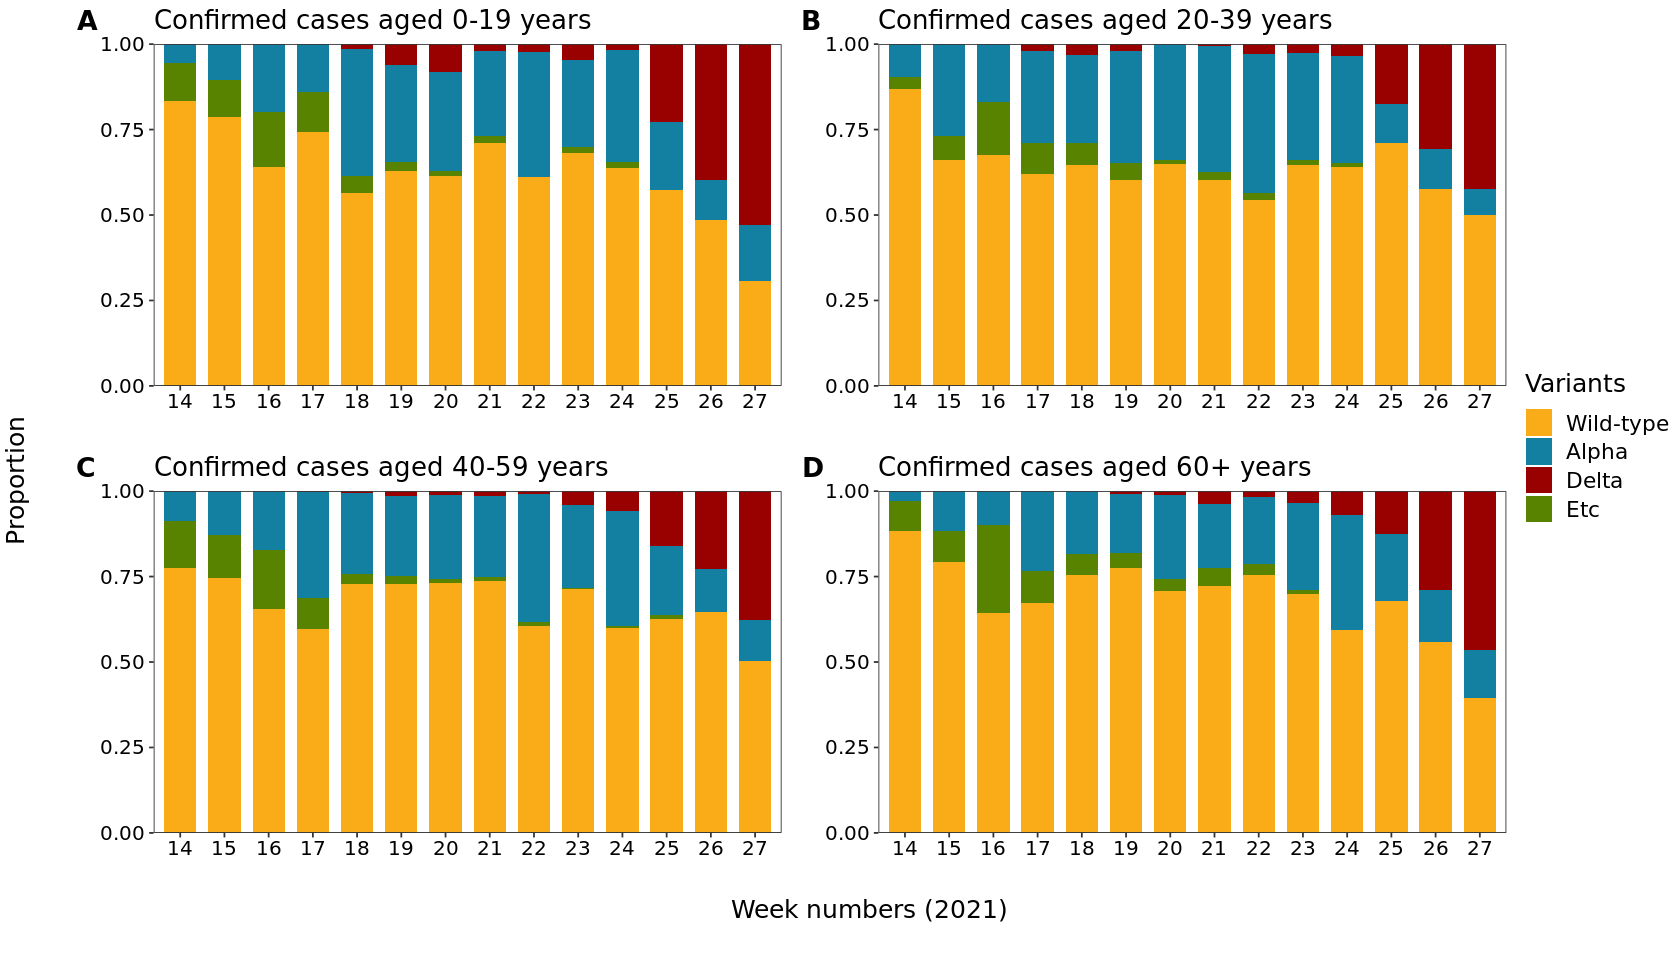

In [17]:
fig_temp[[1]] %<>% filter(week %in% c('14','15','16','17','18','19','20','21','22','23','24','25','26','27'))
fig_temp[[2]] %<>% filter(week %in% c('14','15','16','17','18','19','20','21','22','23','24','25','26','27'))
fig_temp[[3]] %<>% filter(week %in% c('14','15','16','17','18','19','20','21','22','23','24','25','26','27'))
fig_temp[[4]] %<>% filter(week %in% c('14','15','16','17','18','19','20','21','22','23','24','25','26','27'))

options(repr.plot.width=8,repr.plot.height=5)

fig_temp[[1]] %>% 
    ggplot() + 
    geom_bar(aes(x=week, y=prop, fill=group), stat='identity', width=0.73) +
    scale_fill_manual("Variants",
                      values=c('Alpha'="#1380A1", 'Wild-type'="#FAAB18", 
                               'Delta'="#990000", 'Etc'="#588300"),
                      breaks=c('Wild-type','Alpha','Delta','Etc')) +
    ggtitle("Confirmed cases aged 0-19 years") +
    labs(x="", y="") +
    theme(text = element_text(size=13, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 13)) +
    scale_y_continuous(expand = c(0, 0)) +
    coord_cartesian(ylim = c(0,1)) -> Fig1

fig_temp[[2]] %>% 
    ggplot() + 
    geom_bar(aes(x=week, y=prop, fill=group), stat='identity', width=0.73) +
    scale_fill_manual("Variants",
                      values=c('Alpha'="#1380A1", 'Wild-type'="#FAAB18", 
                               'Delta'="#990000", 'Etc'="#588300"),
                      breaks=c('Wild-type','Alpha','Delta','Etc')) +
    ggtitle("Confirmed cases aged 20-39 years") +
    labs(x="", y="") +
    theme(text = element_text(size=13, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 13)) +
    scale_y_continuous(expand = c(0, 0)) +
    coord_cartesian(ylim = c(0,1)) -> Fig2

fig_temp[[3]] %>% 
    ggplot() + 
    geom_bar(aes(x=week, y=prop, fill=group), stat='identity', width=0.73) +
    scale_fill_manual("Variants",
                      values=c('Alpha'="#1380A1", 'Wild-type'="#FAAB18", 
                               'Delta'="#990000", 'Etc'="#588300"),
                      breaks=c('Wild-type','Alpha','Delta','Etc')) +
    ggtitle("Confirmed cases aged 40-59 years") +
    labs(x="", y="") +
    theme(text = element_text(size=13, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 13)) +
    scale_y_continuous(expand = c(0, 0)) +
    coord_cartesian(ylim = c(0,1)) -> Fig3

fig_temp[[4]] %>% 
    ggplot() + 
    geom_bar(aes(x=week, y=prop, fill=group), stat='identity', width=0.73) +
    scale_fill_manual("Variants",
                      values=c('Alpha'="#1380A1", 'Wild-type'="#FAAB18", 
                               'Delta'="#990000", 'Etc'="#588300"),
                      breaks=c('Wild-type','Alpha','Delta','Etc')) +
    ggtitle("Confirmed cases aged 60+ years") +
    labs(x="", y="") +
    theme(text = element_text(size=13, family="sans",color="black"),
          axis.text = element_text(size=12, family="sans",color="black"),
          panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
          legend.title = element_text(size = 15),
          legend.text = element_text(size = 13)) +
    scale_y_continuous(expand = c(0, 0)) +
    coord_cartesian(ylim = c(0,1)) -> Fig4

options(repr.plot.width=14,repr.plot.height=8)
ggarrange(Fig1, Fig2, Fig3, Fig4, ncol = 2, nrow = 2, 
          labels = c("A", "B", "C", "D"), font.label = list(size = 16),
          common.legend = TRUE, legend="right") -> Figure_total

annotate_figure(Figure_total,
                left = text_grob("Proportion\n", size = 15, rot=90),
                bottom = text_grob("Week numbers (2021) \n", size = 15)) -> Figure_total

Figure_total

ggsave("../figures/Figure S4. Proportion of variants.png", width = 14, height = 8)

# Baseline model

In [18]:
time_delay <- 9

In [19]:
#### data for constructing the NGM
(start_date <- as.Date("2020-11-07") + time_delay)
(end_date <- as.Date("2020-11-18") + time_delay)

[1] "2020-11-16"

[1] "2020-11-27"

In [20]:
#### incubation period (Linton et al, 2020)
inc_fit = list(meanlog=1.519, sdlog=0.615)
incubation <- function(t){plnorm(t, inc_fit$meanlog, inc_fit$sdlog) - plnorm(t-1, inc_fit$meanlog, inc_fit$sdlog)}


#### right-truncated time delay from illness onset to reporting (estimated from ICN dataset)
rep_fit = list(shape=param[1], scale=param[2])
onsettolabconf <- function(t){pweibull(t,  shape=rep_fit$shape, scale=rep_fit$scale) - 
                              pweibull(t-1, shape=rep_fit$shape, scale=rep_fit$scale)}

#### time delay from infection to reporting
infectiontoreport <- function(t){convolve(onsettolabconf(t),rev(incubation(t)),type = c("open"))}
infectiontoreport <- function(t){convolve(onsettolabconf(1:t),rev(incubation(1:t)),type = c("open"))}

#### generation time distribution (Nishiura, et al, 2020)
gi_fit = list(shape=2.305, scale=5.452)
generation <- function(t){pweibull(t, shape = gi_fit$shape, scale = gi_fit$scale) - 
                          pweibull(t-1, shape = gi_fit$shape, scale = gi_fit$scale)}

### Initial conditions for the Model 1

In [21]:
#### total population size in Korea
popsize <- c(8932023, 13694461, 16783392, 11939384)
init_Sv <- c(0, 1520589, 2229953, 10477027)

(init_Sv/popsize -> vac_prop)
(init_Sv/popsize*0.8 -> vac_prop)

read_excel("../data/vac_scenario.xlsx", sheet="current") -> vac_prop_org
read_excel("../data/vac_scenario.xlsx", sheet="sc_10") -> vac_prop_sc10
read_excel("../data/vac_scenario.xlsx", sheet="sc_20") -> vac_prop_sc20
read_excel("../data/vac_scenario.xlsx", sheet="sc_child") -> vac_prop_child
read_excel("../data/vac_scenario.xlsx", sheet="addition") -> vac_prop_add

vac_prop_org[rev(rownames(vac_prop_org)), ] -> vac_prop_org
vac_prop_sc10[rev(rownames(vac_prop_sc10)), ] -> vac_prop_sc10
vac_prop_sc20[rev(rownames(vac_prop_sc20)), ] -> vac_prop_sc20
vac_prop_child[rev(rownames(vac_prop_child)), ] -> vac_prop_child
vac_prop_add[rev(rownames(vac_prop_add)), ] -> vac_prop_add

(vac_prop <- c(as.numeric(vac_prop_org[1,2]), as.numeric(vac_prop_org[2,2]),
               as.numeric(vac_prop_org[3,2]),(as.numeric(vac_prop_org[4,2])+0.15)))

[1] 0.0000000 0.1110368 0.1328666 0.8775182

[1] 0.00000000 0.08882943 0.10629332 0.70201458

[1] 0.00000000 0.05357644 0.06300203 0.56936042

In [22]:
read_excel("../data/vac_scenario.xlsx", sheet="current") -> vac_prop_org
read_excel("../data/vac_scenario.xlsx", sheet="sc_10") -> vac_prop_sc10
read_excel("../data/vac_scenario.xlsx", sheet="sc_20") -> vac_prop_sc20
read_excel("../data/vac_scenario.xlsx", sheet="sc_child") -> vac_prop_child
read_excel("../data/vac_scenario.xlsx", sheet="addition") -> vac_prop_add

vac_prop_org[rev(rownames(vac_prop_org)), ] -> vac_prop_org
vac_prop_sc10[rev(rownames(vac_prop_sc10)), ] -> vac_prop_sc10
vac_prop_sc20[rev(rownames(vac_prop_sc20)), ] -> vac_prop_sc20
vac_prop_child[rev(rownames(vac_prop_child)), ] -> vac_prop_child
vac_prop_add[rev(rownames(vac_prop_add)), ] -> vac_prop_add

adj_60 <- 0.15


vac_prop_org[,-1] -> vac_prop1; vac_prop1[4,]+adj_60 -> vac_prop1[4,]
vac_prop_sc10[,-1] -> vac_prop2; vac_prop2[4,]+adj_60 -> vac_prop2[4,]
vac_prop_sc20[,-1] -> vac_prop3; vac_prop3[4,]+adj_60 -> vac_prop3[4,]
vac_prop_child[,-1] -> vac_prop4; vac_prop4[4,]+adj_60 -> vac_prop4[4,]
vac_prop_add[,-1] -> vac_prop5; vac_prop5[4,]+adj_60 -> vac_prop5[4,]

In [23]:
data_1 %<>% rename(group1 = n); data_2 %<>% rename(group2 = n);
data_3 %<>% rename(group3 = n); data_4 %<>% rename(group4 = n);

cbind(data_1, data_2, data_3, data_4) %>% dplyr::select(group1, group2, group3, group4) -> temp_group
cbind(data_1[,1], temp_group) -> master_df
colnames(master_df) <- c("Date", "group1", "group2", "group3", "group4")

In [24]:
burn <- 21 

#### initial values for recovered cases
master_df %>% filter(Date >= (start_date-(burn-1))) %>% filter(Date <= end_date) %>% dplyr::select(-Date) ->  init_value

(master_df %>% filter(Date <= (start_date-(burn-1))) %>% dplyr::select(-Date) %>% 
colSums() %>% sum() %>% as.numeric() -> cum_cases)
(appx_cum_cases = 26000)

total_N = sum(init_value$group1)+sum(init_value$group2)+sum(init_value$group3)+sum(init_value$group4)
c(sum(init_value$group1)/total_N, sum(init_value$group2)/total_N,
  sum(init_value$group3)/total_N, sum(init_value$group4)/total_N) -> age_prop
round(appx_cum_cases*age_prop) -> init_recover

[1] 26043

[1] 26000

### Initial conditions for the Model 2

In [25]:
Start_renewal <- (as.Date("2021-06-13")+time_delay) #### Start from week 21: week 24 - 20 days of burn-in period

master_df %>% filter(Date >= Start_renewal-(burn-1)) %>% 
mutate(Week = strftime(Date, "%V"))-> variant_df

groups <- c("group1", "group2", "group3", "group4")
variant_dff <- list()

for (g in 1:(length(unique(master_prop$group)))){
    
    variant_df %>% dplyr::select(Date, Week, groups[g]) -> variant_temp
    prop_list[[g]] %>% dplyr::select(date, 'Wild-type', Alpha, Delta, Etc) %>% 
    rename(Week = date, Wild='Wild-type') -> prop_temp
    merge(variant_temp, prop_temp, by=c("Week")) %>% rename(case=groups[g]) %>%
    mutate(exp_conv = case*Wild, exp_alpha = case*Alpha,
           exp_delta = case*Delta, exp_etc = case*Etc) %>%
    dplyr::select(Week, Date, case, exp_conv, exp_alpha, exp_delta, exp_etc) -> variant_dff[[g]]
    
    as.Date(variant_dff[[g]]$Date) -> variant_dff[[g]]$Date
    variant_dff[[g]] %<>% arrange(Date) %>% mutate(t = 0:(nrow(variant_dff[[g]])-1))
}

variant_dff[[2]] %>% head(burn)

,Week,Date,case,exp_conv,exp_alpha,exp_delta,exp_etc,t
,<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,22,2021-06-02,220,119.74684,89.11392,6.497890,4.641350,0
2,22,2021-06-03,226,123.01266,91.54430,6.675105,4.767932,1
3,22,2021-06-04,239,130.08861,96.81013,7.059072,5.042194,2
4,22,2021-06-05,241,131.17722,97.62025,7.118143,5.084388,3
5,22,2021-06-06,186,101.24051,75.34177,5.493671,3.924051,4
6,23,2021-06-07,171,110.51020,53.51020,4.653061,2.326531,5
7,23,2021-06-08,159,102.75510,49.75510,4.326531,2.163265,6
8,23,2021-06-09,198,127.95918,61.95918,5.387755,2.693878,7
9,23,2021-06-10,216,139.59184,67.59184,5.877551,2.938776,8


In [26]:
variant_dff[[2]] %>% as.data.frame() %>% mutate(adjusted_Date = Date-time_delay,
                                                adjusted_Week = strftime(adjusted_Date, "%V")) %>%
mutate(adjusted_Week2 = as.numeric(adjusted_Week)) %>%
mutate(adjusted_Week2 = case_when(t<=20 ~ 24,
                                  TRUE~ adjusted_Week2)) %>%
mutate(vac_prop = as.numeric(vac_prop5[1,(adjusted_Week2-23)])) %>% dplyr::select(vac_prop) -> temp_vac1

variant_dff[[2]] %>% as.data.frame() %>% mutate(adjusted_Date = Date-time_delay,
                                                adjusted_Week = strftime(adjusted_Date, "%V")) %>%
mutate(adjusted_Week2 = as.numeric(adjusted_Week)) %>%
mutate(adjusted_Week2 = case_when(t<=20 ~ 24,
                                  TRUE~ adjusted_Week2)) %>%
mutate(vac_prop = as.numeric(vac_prop5[2,(adjusted_Week2-23)])) %>% dplyr::select(vac_prop) -> temp_vac2

variant_dff[[2]] %>% as.data.frame() %>% mutate(adjusted_Date = Date-time_delay,
                                                adjusted_Week = strftime(adjusted_Date, "%V")) %>%
mutate(adjusted_Week2 = as.numeric(adjusted_Week)) %>%
mutate(adjusted_Week2 = case_when(t<=20 ~ 24,
                                  TRUE~ adjusted_Week2)) %>%
mutate(vac_prop = as.numeric(vac_prop5[3,(adjusted_Week2-23)])) %>% dplyr::select(vac_prop) -> temp_vac3

variant_dff[[2]] %>% as.data.frame() %>% mutate(adjusted_Date = Date-time_delay,
                                                adjusted_Week = strftime(adjusted_Date, "%V")) %>%
mutate(adjusted_Week2 = as.numeric(adjusted_Week)) %>%
mutate(adjusted_Week2 = case_when(t<=20 ~ 24,
                                  TRUE~ adjusted_Week2)) %>%
mutate(vac_prop = as.numeric(vac_prop5[4,(adjusted_Week2-23)])) %>% dplyr::select(vac_prop) -> temp_vac4

cbind(temp_vac1, temp_vac2, temp_vac3, temp_vac4) -> vac_prop

In [27]:
vac_prop %>% head()

,vac_prop,vac_prop,vac_prop,vac_prop
,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0.05357644,0.06300203,0.5693604
2,0,0.05357644,0.06300203,0.5693604
3,0,0.05357644,0.06300203,0.5693604
4,0,0.05357644,0.06300203,0.5693604
5,0,0.05357644,0.06300203,0.5693604
6,0,0.05357644,0.06300203,0.5693604


In [28]:
#### age group version without back-projection
temp_conv <- list(); temp_alpha <- list(); temp_delta <- list(); temp_etc <- list()

for(k in 1:4){
    variant_dff[[k]] %>% arrange(Date) %>% dplyr::select(exp_conv) -> temp_conv[[k]]
    variant_dff[[k]] %>% arrange(Date) %>% dplyr::select(exp_alpha) -> temp_alpha[[k]]
    variant_dff[[k]] %>% arrange(Date) %>% dplyr::select(exp_delta) -> temp_delta[[k]]
    variant_dff[[k]] %>% arrange(Date) %>% dplyr::select(exp_etc) -> temp_etc[[k]]}


do.call(cbind, temp_conv) -> master_conv
do.call(cbind, temp_alpha) -> master_alpha
do.call(cbind, temp_delta) -> master_delta
do.call(cbind, temp_etc) -> master_etc

colnames(master_conv) <- c("group1", "group2", "group3", "group4")
colnames(master_alpha) <- c("group1", "group2", "group3", "group4")
colnames(master_delta) <- c("group1", "group2", "group3", "group4")
colnames(master_etc) <- c("group1", "group2", "group3", "group4")

### 2-3-2. Model for the calibration

In [29]:
### fixed parameters for the base model
epsilon = 1/3
sigma = 1/5
omega = 1/18
IFR <- c(0.00001, 0.02, 0.21, 8.36)*0.01
SR <- c(0.001, 0.157, 1.071, 9.129)*0.01

(nrow(init_value) -> lgth)

[1] 32

In [30]:
loglike <- function(param){
    
    #### risk of death among severe cases
    lk_binom <- rep(0, 4)
    
    for (k in 1:4){dbinom(IFR[k]*10000000, size = SR[k]*10000000, prob = param[k], log=TRUE) -> lk_binom[k]}
    return(sum(-lk_binom))
}
    
#### Optim
param0 = c(0.01, 0.127388535031847, 0.196078431372549, 0.915762953225983)

options(warn=-1)
opt_FR <- optim(param0, fn=loglike, method=c("BFGS"), control=list(maxit=10000))
options(warn=0)  

opt_FR

$par
[1] 0.0100000 0.1273885 0.1960784 0.9157630

$value
[1] 17.93231

$counts
function gradient 
      23        1 

$convergence
[1] 0

$message
NULL

In [31]:
time_org <- proc.time()    

loglike <- function(param){
    
    
    llk_total <- rep(0, lgth)
    
    
    #### fixed parameters for the base model
    epsilon = 1/3
    sigma = 1/5
    omega = 1/18
    IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
    SR <- c(0.001, 0.157, 1.071, 9.129)*0.01  

    
    #### SEIR compartments 
    S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))

    pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))

    Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    llk = data.frame(matrix(0, ncol=ncol(init_value), nrow=lgth))


    #### initail conditions for the calibration
    for (g in 1:ncol(init_value)){         
        S[1,g] <- popsize[g] - (init_value[1,g]*3 + init_value[2,g]*5 + init_recover[g])
        E[1,g] <- init_value[1,g]*3
        I[1,g] <- init_value[2,g]*5
        H[1,g] <- 0  
        D[1,g] <- 0
        R[1,g] <- init_recover[g]     
        
        pSE[1,g] <- 0           
        pEI[1,g] <- 0
        pIR[1,g] <- 0
        pIH[1,g] <- 0
        pHR[1,g] <- 0
        pHD[1,g] <- 0
    }


    #### Dynamics of SEIDR model
    for (t in 2:lgth){
        
        for (g in 1:ncol(init_value)){ 
      
            pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*(
                adj_contact[g,1]*I[t-1,1]/(S[t-1,1]+E[t-1,1]+I[t-1,1]+R[t-1,1]) + 
                adj_contact[g,2]*I[t-1,2]/(S[t-1,2]+E[t-1,2]+I[t-1,2]+R[t-1,2]) +
                adj_contact[g,3]*I[t-1,3]/(S[t-1,3]+E[t-1,3]+I[t-1,3]+R[t-1,3]) + 
                adj_contact[g,4]*I[t-1,4]/(S[t-1,4]+E[t-1,4]+I[t-1,4]+R[t-1,4])))))

            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))


            S[t,g] <- S[t-1,g] - pSE[t,g] 
            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g] 
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHD[t,g] - pHR[t,g] 
            D[t,g] <- D[t-1,g] + pHD[t,g] 
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] 

            I[,g][I[,g]<0] <- 0
            pSE[,g][pSE[,g]<0] <- 0

            
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled[t,g]

            llk[t,g] <- -(-Reported_modelled[t,g]+init_value[t,g]*log(Reported_modelled[t,g])-lgamma(init_value[t,g]+1))
        }  
        
        llk_total[t] = sum(llk[t,])

    }

    
    #### generating the NGM
    temp <- matrix(NA, 4, 4)
    NGM <- matrix(NA, 4, 4)
    
    (param[1:4]*param[5]) -> sus_param
    for (m in 1:4){adj_contact[m,]*sus_param[m]-> temp[m,]}
    for (n in 1:4){temp[,n]*1/sigma -> NGM[,n]}
 
    llk_conv <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
    llk_alpha <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
    llk_delta <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
    llk_etc <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
    

    
    #### for wild type  
    Cs <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t))  
    for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))     

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,1])+
                       ((variant_dff[[2]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,2])+
                       ((variant_dff[[3]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,3])+  
                       ((variant_dff[[4]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,4])
            }      

            Cs[m,t] = sum(Css)*(1-vac_prop[t,m])  
            Cs[m,t][Cs[m,t]<=0] <- 1e-5
            llk_conv[m,t] = -Cs[m,t]+master_conv[t+1,m]*log(Cs[m,t])-lgamma(master_conv[t+1,m]+1)
        }
    }          
    llk_conv_total <- -sum(llk_conv)
    
    
    #### for Alpha
    Cs <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
     for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))     

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,1]*param[6])+
                       ((variant_dff[[2]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,2]*param[6])+
                       ((variant_dff[[3]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,3]*param[6])+  
                       ((variant_dff[[4]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,4]*param[6])
            }      

            Cs[m,t] = sum(Css)*(1-vac_prop[t,m])  
            Cs[m,t][Cs[m,t]<=0] <- 1e-5
            llk_alpha[m,t] = -Cs[m,t]+master_alpha[t+1,m]*log(Cs[m,t])-lgamma(master_alpha[t+1,m]+1)
        }
    }          
    llk_alpha_total <- -sum(llk_alpha)  
    

    #### for Delta
    Cs <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t))  
     for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))  

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,1]*param[7])+
                       ((variant_dff[[2]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,2]*param[7])+
                       ((variant_dff[[3]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,3]*param[7])+  
                       ((variant_dff[[4]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,4]*param[7])
            }      

            Cs[m,t] = sum(Css)*(1-vac_prop[t,m]) 
            Cs[Cs[m,t]<=0] <- 1e-5
            llk_delta[m,t] = -Cs[m,t]+master_delta[t+1,m]*log(Cs[m,t])-lgamma(master_delta[t+1,m]+1)
        }
    }          
    llk_delta_total <- -sum(llk_delta)   
    
    
    #### for Etc
    Cs <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
     for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))    

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,1]*param[8])+
                       ((variant_dff[[2]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,2]*param[8])+
                       ((variant_dff[[3]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,3]*param[8])+  
                       ((variant_dff[[4]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,4]*param[8])
            }      

            Cs[m,t] = sum(Css)*(1-vac_prop[t,m]) 
            Cs[m,t][Cs[m,t]<=0] <- 1e-5
            llk_etc[m,t] = -Cs[m,t]+master_etc[t+1,m]*log(Cs[m,t])-lgamma(master_etc[t+1,m]+1)
        }
    }          
    llk_etc_total <- -sum(llk_etc)
    
    
    LK_variants <- (llk_conv_total + llk_alpha_total + llk_delta_total + llk_etc_total)
  
    
    return(sum(llk_total[burn:lgth])+LK_variants)
}  

## Optim
param0 = c(0.00839345001544167, 0.0213549791943258, 0.0225932358342151, 0.0611640144713435,
           0.9, 1.2, 2.0, 0.3)

options(warn=-1)

opt_est <- optim(param0, fn=loglike, method=c("BFGS"), control=list(maxit=10000), hessian=TRUE)
options(warn=0)  

(proc.time()-time_org)

opt_est

opt_est$par -> est_param
opt_est$hessian -> est_param_hes
saveRDS(est_param,"../result/rds/estimated_ui_param.rds")
saveRDS(est_param_hes,"../result/rds/estimated_ui_CIs.rds")

   user  system elapsed 
350.258   0.130 350.390 

36035582.8733,6773676.5327,6215480.9954,737840.01572,295077.45840,38581.3686249036837,59962.6102886361405,570.30358
6773676.5327,32111120.4518,12382067.0634,1446718.99139,327576.99919,39847.9592262219739,62621.4716756408015,600.56635
6215480.9954,12382067.0634,24312495.9958,1323408.56397,262725.50937,34026.3090662915565,48965.0275206372462,554.84823
737840.0157,1446718.9914,1323408.5640,1144761.69491,33428.35153,4486.5354003604807,6127.6837379011795,64.75545
295077.4584,327576.9992,262725.5094,33428.35153,20558.94860,2611.4165423223312,3920.9261931887340,40.19064
38581.3686,39847.9592,34026.3091,4486.53540,2611.41654,2638.9093754914938,-0.0000001136868,0.00000
59962.6103,62621.4717,48965.0275,6127.68374,3920.92619,-0.0000001136868,2239.6217405002972,0.00000
570.3036,600.5664,554.8482,64.75545,40.19064,0.0000000000000,0.0000000000000,126.04935


In [32]:
niter = 5000

In [33]:
#### 95% confidence intervals using Hessian matrix
library(MASS)

hes_p <- est_param_hes
fisher_info<-solve(hes_p)

est_param_sample <- mvrnorm(n=niter, mu=est_param, Sigma=fisher_info, tol=1e-25, empirical=FALSE, EISPACK=FALSE)

In [34]:
c(quantile(est_param_sample[,5],0.025),quantile(est_param_sample[,5],0.5),quantile(est_param_sample[,5],0.975))
c(quantile(est_param_sample[,6],0.025),quantile(est_param_sample[,6],0.5),quantile(est_param_sample[,6],0.975))
c(quantile(est_param_sample[,7],0.025),quantile(est_param_sample[,7],0.5),quantile(est_param_sample[,7],0.975))
c(quantile(est_param_sample[,8],0.025),quantile(est_param_sample[,8],0.5),quantile(est_param_sample[,8],0.975))

2.5%       50%     97.5% 
0.8659964 0.8862727 0.9065149

2.5%       50%     97.5% 
0.8353491 0.8774094 0.9175712

2.5%      50%    97.5% 
1.498635 1.550726 1.603126

2.5%       50%     97.5% 
0.1105871 0.2846817 0.4611687

In [37]:
library(foreach); library(doParallel);
(ncore <- detectCores(logical = FALSE))

Loading required package: iterators

Loading required package: parallel



[1] 48

In [38]:
epsilon = 1/3
sigma = 1/5
omega = 1/18
IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
SR <- c(0.001, 0.157, 1.071, 9.129)*0.01

In [39]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

fitness_CIs <- list()
fitness_CIs <- foreach (k = 1:niter, .packages='dplyr') %dopar% {

    
    param <- est_param_sample[k,]
    llk_total <- rep(0, lgth)


    #### SEIR compartments 
    S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))

    pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))

    Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
    llk = data.frame(matrix(0, ncol=ncol(init_value), nrow=lgth))


    #### initail conditions for the calibration
    for (g in 1:ncol(init_value)){         
        S[1,g] <- popsize[g] - (init_value[1,g]*3 + init_value[2,g]*5 + init_recover[g])
        E[1,g] <- init_value[1,g]*3
        I[1,g] <- init_value[2,g]*5
        H[1,g] <- 0  
        D[1,g] <- 0
        R[1,g] <- init_recover[g]    
        
        pSE[1,g] <- 0           
        pEI[1,g] <- 0
        pIR[1,g] <- 0
        pIH[1,g] <- 0
        pHR[1,g] <- 0
        pHD[1,g] <- 0
    }


    #### Dynamics of SEIDR model
    for (t in 2:lgth){

        for (g in 1:ncol(init_value)){ 

            pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*(
                adj_contact[g,1]*I[t-1,1]/(S[t-1,1]+E[t-1,1]+I[t-1,1]+R[t-1,1]) + 
                adj_contact[g,2]*I[t-1,2]/(S[t-1,2]+E[t-1,2]+I[t-1,2]+R[t-1,2]) +
                adj_contact[g,3]*I[t-1,3]/(S[t-1,3]+E[t-1,3]+I[t-1,3]+R[t-1,3]) + 
                adj_contact[g,4]*I[t-1,4]/(S[t-1,4]+E[t-1,4]+I[t-1,4]+R[t-1,4])))))

            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))


            S[t,g] <- S[t-1,g] - pSE[t,g] 
            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g] 
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHD[t,g] - pHR[t,g] 
            D[t,g] <- D[t-1,g] + pHD[t,g] 
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] 

            I[,g][I[,g]<0] <- 0
            pSE[,g][pSE[,g]<0] <- 0

            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled[t,g]
        }
    }
    
    Reported_modelled[21:lgth,] -> Reported_modelled

    Reported_modelled[,1] %>% as.data.frame() -> fit_1
    Reported_modelled[,2] %>% as.data.frame() -> fit_2
    Reported_modelled[,3] %>% as.data.frame() -> fit_3
    Reported_modelled[,4] %>% as.data.frame() -> fit_4

    rbind(fit_1, fit_2, fit_3, fit_4) -> master_modeled
    master_modeled %>% rename(n =".") -> fitness_CIs[[k]]    
}

stopCluster(myCluster)
(proc.time()-time_org)

do.call("cbind", fitness_CIs) -> fitness_CIs_final
saveRDS(fitness_CIs[[1]], "../result/rds/fitness_CIs_temp.rds")
saveRDS(fitness_CIs_final, "../result/rds/fitness_CIs_final.rds")

   user  system elapsed 
  4.791   0.864  67.860 

### 2-3-3. simulation with estimated parameters

In [40]:
master_df_figure %<>% filter(published >= start_date) %>% filter(published <= end_date) %>% dplyr::select(-t)

In [41]:
#### checking the fitness with figures
readRDS("../result/rds/fitness_CIs_temp.rds") -> fitness_CIs_temp
readRDS("../result/rds/fitness_CIs_final.rds") -> fitness_CIs_final

fitness_CIs_temp -> fit_result_lower
fitness_CIs_temp-> fit_result_median
fitness_CIs_temp -> fit_result_upper

for (k in 1:nrow(fitness_CIs_temp)){
    quantile(fitness_CIs_final[k,],0.025) -> fit_result_lower[k,1]
    quantile(fitness_CIs_final[k,],0.5) -> fit_result_median[k,1]
    quantile(fitness_CIs_final[k,],0.975) -> fit_result_upper[k,1]
}

age_group <- c("0-19_modeled", "20-39_modeled", "40-59_modeled", "60+_modeled")
as.data.frame(rep(age_group, each=(lgth-20))) -> temp

cbind(as.data.frame(master_df_figure$published), fit_result_median, temp) -> fit_result_median
cbind(as.data.frame(master_df_figure$published), fit_result_lower) -> fit_result_lower
cbind(as.data.frame(master_df_figure$published), fit_result_upper) -> fit_result_upper

colnames(fit_result_median) <- c("published", "n", "age_group")
colnames(fit_result_lower) <- c("published", "n")
colnames(fit_result_upper) <- c("published", "n")

rbind(master_df_figure[1:(lgth-20),], fit_result_median[1:(lgth-20),]) -> compare_1
rbind(master_df_figure[((lgth-20)+1):((lgth-20)*2),], fit_result_median[((lgth-20)+1):((lgth-20)*2),]) -> compare_2
rbind(master_df_figure[((lgth-20)*2+1):((lgth-20)*3),], fit_result_median[((lgth-20)*2+1):((lgth-20)*3),]) -> compare_3
rbind(master_df_figure[((lgth-20)*3+1):((lgth-20)*4),], fit_result_median[((lgth-20)*3+1):((lgth-20)*4),]) -> compare_4

Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data frames”
Warning message in xtfrm.data.frame(x):
“cannot xtfrm data fra

In [43]:
compare_1 %<>% mutate(age_group = rep(c("Observed", "Modeled"), each=(lgth-20)))
compare_2 %<>% mutate(age_group = rep(c("Observed", "Modeled"), each=(lgth-20)))
compare_3 %<>% mutate(age_group = rep(c("Observed", "Modeled"), each=(lgth-20)))
compare_4 %<>% mutate(age_group = rep(c("Observed", "Modeled"), each=(lgth-20)))

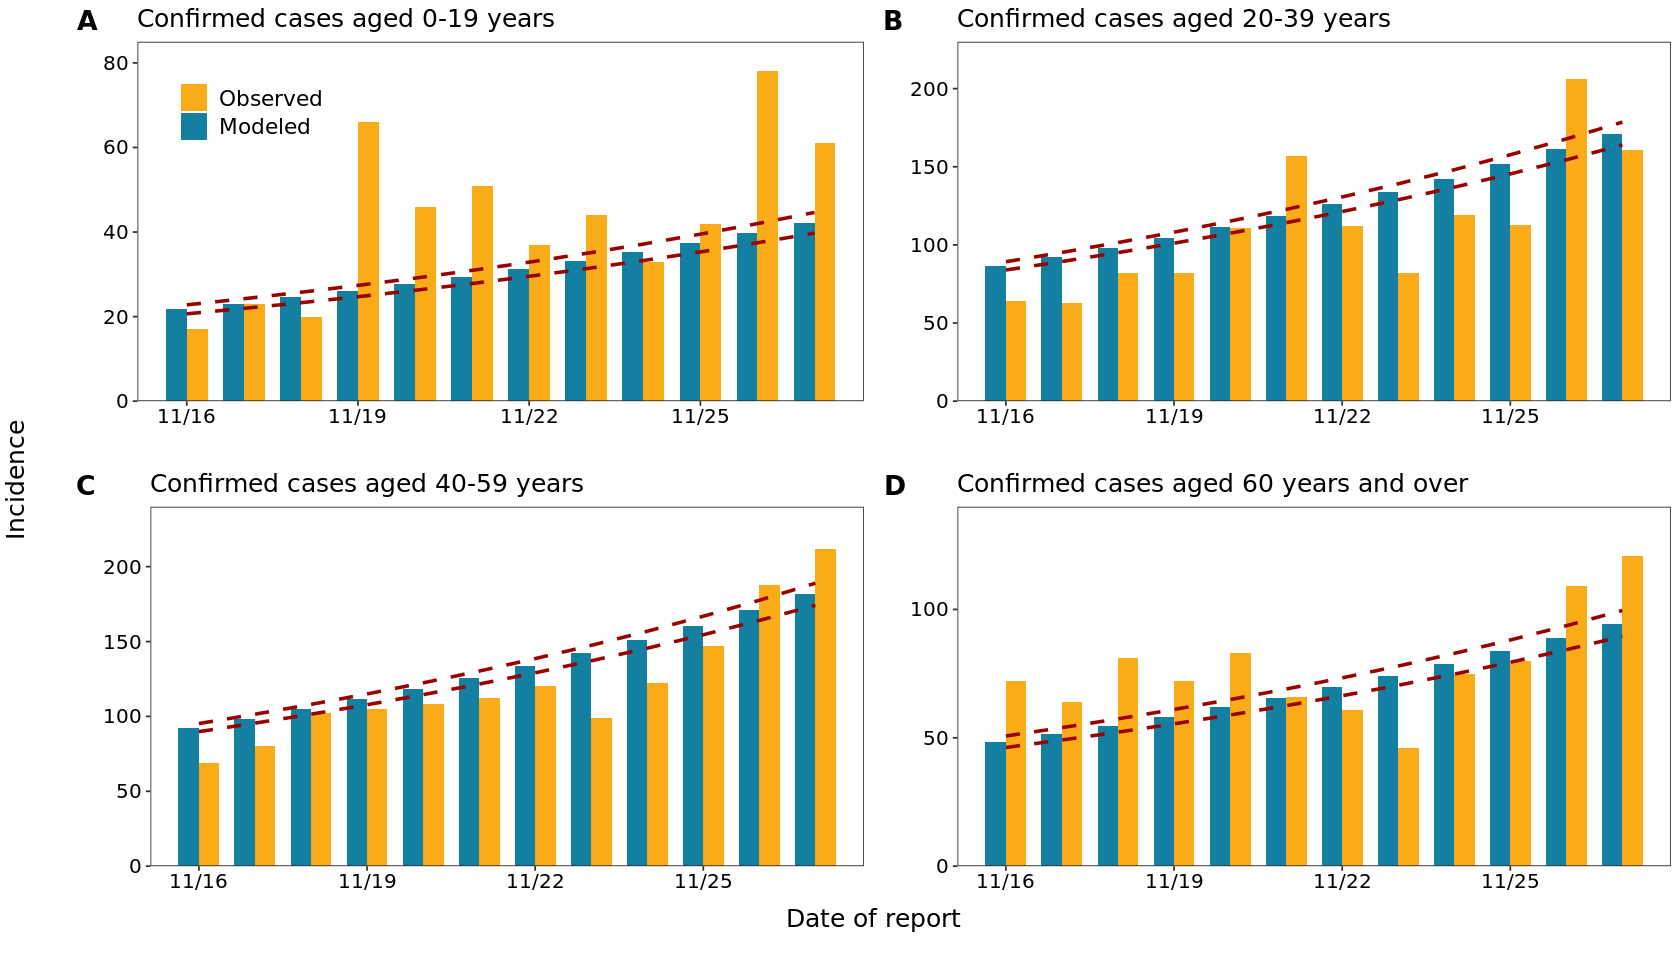

In [44]:
options(repr.plot.width=8,repr.plot.height=5)
range = c(start_date, end_date)

#### Age group 1
compare_1%>% 
ggplot() + 
geom_bar(aes(x=published, y=n, fill=age_group, group=age_group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("Modeled"="#1380A1", "Observed"="#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=fit_result_lower[1:(lgth-20),], aes(x=published, y=n), color="#990000", linetype = "dashed", size=1) +
geom_line(data=fit_result_upper[1:(lgth-20),], aes(x=published, y=n), color="#990000", linetype = "dashed", size=1) +
ggtitle("Confirmed cases aged 0-19 years") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 13),
      plot.title = element_text(size=15, family="sans",color="black")) +
scale_x_date(date_labels="%m/%d",date_breaks  ="3 days", expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,85)) +
theme(legend.position = c(0.15, 0.848)) -> fig1

options(repr.plot.width=8,repr.plot.height=5)


#### Age group 2
compare_2 %>% 
ggplot() + 
geom_bar(aes(x=published, y=n, fill=age_group, group=age_group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18")) +
geom_line(data=fit_result_lower[((lgth-20)+1):((lgth-20)*2),], aes(x=published, y=n), 
          color="#990000", linetype = "dashed", size=1) +
geom_line(data=fit_result_upper[((lgth-20)+1):((lgth-20)*2),], aes(x=published, y=n), 
          color="#990000", linetype = "dashed", size=1) +
ggtitle("Confirmed cases aged 20-39 years") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      plot.title = element_text(size=15, family="sans",color="black")) +
scale_x_date(date_labels="%m/%d",date_breaks  ="3 days", expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,230)) -> fig2

options(repr.plot.width=8,repr.plot.height=5)

#### Age group 3
compare_3 %>% 
ggplot() + 
geom_bar(aes(x=published, y=n, fill=age_group, group=age_group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18")) +
geom_line(data=fit_result_lower[((lgth-20)*2+1):((lgth-20)*3),], aes(x=published, y=n), 
          color="#990000", linetype = "dashed", size=1) +
geom_line(data=fit_result_upper[((lgth-20)*2+1):((lgth-20)*3),], aes(x=published, y=n), 
          color="#990000", linetype = "dashed", size=1) +
ggtitle("Confirmed cases aged 40-59 years") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      plot.title = element_text(size=15, family="sans",color="black")) +
scale_x_date(date_labels="%m/%d",date_breaks  ="3 days", expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,240)) -> fig3

options(repr.plot.width=8,repr.plot.height=5)

#### Age group 4
compare_4 %>% 
ggplot() + 
geom_bar(aes(x=published, y=n, fill=age_group, group=age_group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18")) +
geom_line(data=fit_result_lower[((lgth-20)*3+1):((lgth-20)*4),], aes(x=published, y=n), 
          color="#990000", linetype = "dashed", size=1) +
geom_line(data=fit_result_upper[((lgth-20)*3+1):((lgth-20)*4),], aes(x=published, y=n), 
          color="#990000", linetype = "dashed", size=1) +
ggtitle("Confirmed cases aged 60 years and over") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.position="none",
      plot.title = element_text(size=15, family="sans",color="black")) +
scale_x_date(date_labels="%m/%d",date_breaks  ="3 days", expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,140))  -> fig4

options(warn=-1)
library(ggpubr)
options(repr.plot.width=14,repr.plot.height=8)
ggarrange(fig1, fig2, fig3, fig4, ncol = 2, nrow = 2, 
          labels = c("A", "B", "C", "D"), font.label = list(size = 16)) -> Fit_figure

annotate_figure(Fit_figure,
                left = text_grob("Incidence\n", size = 15, rot=90),
                bottom=text_grob("Date of report", size=15, vjust=-1))

ggsave("../figures/Figure S3. Fitting.png", width = 14, height = 8)
options(warn=0)

## 2-4. Estimated next generation matrix

In [45]:
temp <- matrix(NA, 4, 4)
NGM <- matrix(NA, 4, 4)
temp_R <- rep(0, niter)
NGM_list <- list()

for (k in 1:niter){
    for (m in 1:4){
        adj_contact[m,]*est_param_sample[k,m] -> temp[m,]}

    for (n in 1:4){
        temp[,n]*1/sigma -> NGM[,n]}
        
        NGM -> NGM_list[[k]]

    (eigen(NGM)$values[1] -> temp_R[k])
}

#### estimated baseline R and its 95% CIs
c(quantile(temp_R,0.025), quantile(temp_R,0.5), quantile(temp_R,0.975))

2.5%      50%    97.5% 
1.480076 1.493820 1.507446

In [46]:
#### 95% CIs for each element in the NGM
temp <- rep(0, niter)
NGM -> NGM_lower; NGM-> NGM_upper

for (m in 1:nrow(NGM)){
    for (n in 1:ncol(NGM)){
        for (g in 1:niter){
            NGM_list[[g]][m,n] -> temp[g]
            quantile(temp,0.025) -> NGM_lower[m,n]
            quantile(temp,0.975) -> NGM_upper[m,n]
        }
    }
}

NGM_lower
NGM
NGM_upper

0.4753533,0.1566597,0.2043627,0.04526647
0.2314983,0.8352476,0.5495973,0.10998597
0.2636013,0.4797338,0.7051506,0.12286540
0.1772289,0.2914103,0.3729422,0.36315084


0.4838152,0.1594485,0.2080006,0.04607227
0.2361605,0.8520691,0.5606659,0.11220103
0.2636444,0.4798121,0.7052657,0.12288545
0.1880265,0.3091643,0.3956634,0.38527554


0.5106321,0.1682864,0.2195296,0.04862596
0.2401568,0.8664876,0.5701534,0.11409967
0.2738293,0.4983478,0.7325111,0.12763268
0.1907896,0.3137076,0.4014779,0.39093739


In [47]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

fitness_CI2 <- list()
fitness_CI2 <- foreach (k = 1:niter, .packages='dplyr') %dopar% {
    
    param <- est_param_sample[k, (5:8)]
    
    #### generating the NGM
    temp <- matrix(NA, 4, 4)
    NGM <- matrix(NA, 4, 4)
    
    (opt_est$par[1:4]*param[1]) -> sus_param
    for (m in 1:4){adj_contact[m,]*sus_param[m] -> temp[m,]}
    for (n in 1:4){temp[,n]*1/sigma -> NGM[,n]}

    
    #### for wild type  
    Cs_conv <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t))  
    for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))     

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,1])+
                       ((variant_dff[[2]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,2])+
                       ((variant_dff[[3]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,3])+  
                       ((variant_dff[[4]]$exp_conv[t-tau+1])*generation(tau)*NGM[m,4])
            }      

            Cs_conv[m,t] = sum(Css)*(1-vac_prop[t,m]) 
        }
    }          

    
    
    #### for Alpha
    Cs_alpha <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
     for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))     

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,1]*param[2])+
                       ((variant_dff[[2]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,2]*param[2])+
                       ((variant_dff[[3]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,3]*param[2])+  
                       ((variant_dff[[4]]$exp_alpha[t-tau+1])*generation(tau)*NGM[m,4]*param[2])
            }      

            Cs_alpha[m,t] = sum(Css)*(1-vac_prop[t,m])  
        }
    }          

    #### for Delta
    Cs_delta <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t)) 
     for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))  

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,1]*param[3])+
                       ((variant_dff[[2]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,2]*param[3])+
                       ((variant_dff[[3]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,3]*param[3])+  
                       ((variant_dff[[4]]$exp_delta[t-tau+1])*generation(tau)*NGM[m,4]*param[3])
            }      

            Cs_delta[m,t] = sum(Css)*(1-vac_prop[t,m])  
        }
    }          
    
    
    #### for Etc
    Cs_etc <- matrix(0, nrow=ncol(master_conv), ncol=max(variant_dff[[1]]$t))  
     for (m in 1:4){        
  
        for (t in burn:max(variant_dff[[1]]$t)){
           
            Css <- rep(0, max(variant_dff[[1]]$t))    

            for (tau in 1:(t-1)){
            Css[tau] = ((variant_dff[[1]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,1]*param[4])+
                       ((variant_dff[[2]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,2]*param[4])+
                       ((variant_dff[[3]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,3]*param[4])+  
                       ((variant_dff[[4]]$exp_etc[t-tau+1])*generation(tau)*NGM[m,4]*param[4])
            }      

            Cs_etc[m,t] = sum(Css)*(1-vac_prop[t,m])  
        }
    }          

    list(Cs_conv, Cs_alpha, Cs_delta, Cs_etc) -> fitness_CI2[[k]] 
     
}

stopCluster(myCluster)
(proc.time()-time_org)


   user  system elapsed 
  4.037   0.897  49.604 

In [48]:
fitness_CI2[[1]][1] -> temp_Cs; fitness_CI2[[1]][2] -> temp_Alpha
fitness_CI2[[1]][3] -> temp_Delta; fitness_CI2[[1]][4] -> temp_Etc

for(l in 2:niter){
    rbind(as.data.frame(temp_Cs), as.data.frame(fitness_CI2[[l]][1])) -> temp_Cs
    rbind(as.data.frame(temp_Alpha), as.data.frame(fitness_CI2[[l]][2])) -> temp_Alpha
    rbind(as.data.frame(temp_Delta), as.data.frame(fitness_CI2[[l]][3])) -> temp_Delta
    rbind(as.data.frame(temp_Etc), as.data.frame(fitness_CI2[[l]][4])) -> temp_Etc}


#### Wild-type
temp_Cs[1,] -> temp_Cs1; temp_Cs[2,] -> temp_Cs2; temp_Cs[3,] -> temp_Cs3; temp_Cs[4,] -> temp_Cs4

for(l in 1:(niter-1)){
    rbind(as.data.frame(temp_Cs1), as.data.frame(temp_Cs[4*l+1,])) -> temp_Cs1
    rbind(as.data.frame(temp_Cs2), as.data.frame(temp_Cs[4*l+2,])) -> temp_Cs2
    rbind(as.data.frame(temp_Cs3), as.data.frame(temp_Cs[4*l+3,])) -> temp_Cs3
    rbind(as.data.frame(temp_Cs4), as.data.frame(temp_Cs[4*l+4,])) -> temp_Cs4}

ncol(temp_Cs1) -> lgth_temp
temp_Cs1[,(burn:lgth_temp)] %>% t() -> temp_Cs1; temp_Cs2[,(burn:lgth_temp)] %>% t() -> temp_Cs2
temp_Cs3[,(burn:lgth_temp)] %>% t() -> temp_Cs3; temp_Cs4[,(burn:lgth_temp)] %>% t() -> temp_Cs4

as.data.frame(temp_Cs1[,(1:12)]) -> Cs_CI
for (k in 1:nrow(as.data.frame(temp_Cs1[,1]))){quantile(temp_Cs1[k,],0.025) -> Cs_CI[k,1]
                                               quantile(temp_Cs1[k,],0.5) -> Cs_CI[k,2]
                                               quantile(temp_Cs1[k,],0.975) -> Cs_CI[k,3]}

for (k in 1:nrow(as.data.frame(temp_Cs2[,1]))){quantile(temp_Cs2[k,],0.025) -> Cs_CI[k,4]
                                               quantile(temp_Cs2[k,],0.5) -> Cs_CI[k,5]
                                               quantile(temp_Cs2[k,],0.975) -> Cs_CI[k,6]}

for (k in 1:nrow(as.data.frame(temp_Cs3[,1]))){quantile(temp_Cs3[k,],0.025) -> Cs_CI[k,7]
                                               quantile(temp_Cs3[k,],0.5) -> Cs_CI[k,8]
                                               quantile(temp_Cs3[k,],0.975) -> Cs_CI[k,9]}

for (k in 1:nrow(as.data.frame(temp_Cs4[,1]))){quantile(temp_Cs4[k,],0.025) -> Cs_CI[k,10]
                                               quantile(temp_Cs4[k,],0.5) -> Cs_CI[k,11]
                                               quantile(temp_Cs4[k,],0.975) -> Cs_CI[k,12]}

#### Alpha
temp_Alpha[1,] -> temp_Alpha1; temp_Alpha[2,] -> temp_Alpha2; 
temp_Alpha[3,] -> temp_Alpha3; temp_Alpha[4,] -> temp_Alpha4

for(l in 1:(niter-1)){
    rbind(as.data.frame(temp_Alpha1), as.data.frame(temp_Alpha[4*l+1,])) -> temp_Alpha1
    rbind(as.data.frame(temp_Alpha2), as.data.frame(temp_Alpha[4*l+2,])) -> temp_Alpha2
    rbind(as.data.frame(temp_Alpha3), as.data.frame(temp_Alpha[4*l+3,])) -> temp_Alpha3
    rbind(as.data.frame(temp_Alpha4), as.data.frame(temp_Alpha[4*l+4,])) -> temp_Alpha4}

ncol(temp_Alpha1) -> lgth_temp
temp_Alpha1[,(burn:lgth_temp)] %>% t() -> temp_Alpha1; temp_Alpha2[,(burn:lgth_temp)] %>% t() -> temp_Alpha2
temp_Alpha3[,(burn:lgth_temp)] %>% t() -> temp_Alpha3; temp_Alpha4[,(burn:lgth_temp)] %>% t() -> temp_Alpha4

as.data.frame(temp_Alpha1[,(1:12)]) -> Alpha_CI
for (k in 1:nrow(as.data.frame(temp_Alpha1[,1]))){quantile(temp_Alpha1[k,],0.025) -> Alpha_CI[k,1]
                                                  quantile(temp_Alpha1[k,],0.5) -> Alpha_CI[k,2]
                                                  quantile(temp_Alpha1[k,],0.975) -> Alpha_CI[k,3]}

for (k in 1:nrow(as.data.frame(temp_Alpha2[,1]))){quantile(temp_Alpha2[k,],0.025) -> Alpha_CI[k,4]
                                                  quantile(temp_Alpha2[k,],0.5) -> Alpha_CI[k,5]
                                                  quantile(temp_Alpha2[k,],0.975) -> Alpha_CI[k,6]}

for (k in 1:nrow(as.data.frame(temp_Alpha3[,1]))){quantile(temp_Alpha3[k,],0.025) -> Alpha_CI[k,7]
                                                  quantile(temp_Alpha3[k,],0.5) -> Alpha_CI[k,8]
                                                  quantile(temp_Alpha3[k,],0.975) -> Alpha_CI[k,9]}

for (k in 1:nrow(as.data.frame(temp_Alpha4[,1]))){quantile(temp_Alpha4[k,],0.025) -> Alpha_CI[k,10]
                                                  quantile(temp_Alpha4[k,],0.5) -> Alpha_CI[k,11]
                                                  quantile(temp_Alpha4[k,],0.975) -> Alpha_CI[k,12]}


#### Delta
temp_Delta[1,] -> temp_Delta1; temp_Delta[2,] -> temp_Delta2; 
temp_Delta[3,] -> temp_Delta3; temp_Delta[4,] -> temp_Delta4

for(l in 1:(niter-1)){
    rbind(as.data.frame(temp_Delta1), as.data.frame(temp_Delta[4*l+1,])) -> temp_Delta1
    rbind(as.data.frame(temp_Delta2), as.data.frame(temp_Delta[4*l+2,])) -> temp_Delta2
    rbind(as.data.frame(temp_Delta3), as.data.frame(temp_Delta[4*l+3,])) -> temp_Delta3
    rbind(as.data.frame(temp_Delta4), as.data.frame(temp_Delta[4*l+4,])) -> temp_Delta4}

ncol(temp_Delta1) -> lgth_temp
temp_Delta1[,(burn:lgth_temp)] %>% t() -> temp_Delta1; temp_Delta2[,(burn:lgth_temp)] %>% t() -> temp_Delta2
temp_Delta3[,(burn:lgth_temp)] %>% t() -> temp_Delta3; temp_Delta4[,(burn:lgth_temp)] %>% t() -> temp_Delta4

as.data.frame(temp_Delta1[,(1:12)]) -> Delta_CI
for (k in 1:nrow(as.data.frame(temp_Delta1[,1]))){quantile(temp_Delta1[k,],0.025) -> Delta_CI[k,1]
                                                  quantile(temp_Delta1[k,],0.5) -> Delta_CI[k,2]
                                                  quantile(temp_Delta1[k,],0.975) -> Delta_CI[k,3]}

for (k in 1:nrow(as.data.frame(temp_Delta2[,1]))){quantile(temp_Delta2[k,],0.025) -> Delta_CI[k,4]
                                                  quantile(temp_Delta2[k,],0.5) -> Delta_CI[k,5]
                                                  quantile(temp_Delta2[k,],0.975) -> Delta_CI[k,6]}

for (k in 1:nrow(as.data.frame(temp_Delta3[,1]))){quantile(temp_Delta3[k,],0.025) -> Delta_CI[k,7]
                                                  quantile(temp_Delta3[k,],0.5) -> Delta_CI[k,8]
                                                  quantile(temp_Delta3[k,],0.975) -> Delta_CI[k,9]}

for (k in 1:nrow(as.data.frame(temp_Delta4[,1]))){quantile(temp_Delta4[k,],0.025) -> Delta_CI[k,10]
                                                  quantile(temp_Delta4[k,],0.5) -> Delta_CI[k,11]
                                                  quantile(temp_Delta4[k,],0.975) -> Delta_CI[k,12]}


#### Etc
temp_Etc[1,] -> temp_Etc1; temp_Etc[2,] -> temp_Etc2; temp_Etc[3,] -> temp_Etc3; temp_Etc[4,] -> temp_Etc4

for(l in 1:(niter-1)){
    rbind(as.data.frame(temp_Etc1), as.data.frame(temp_Etc[4*l+1,])) -> temp_Etc1
    rbind(as.data.frame(temp_Etc2), as.data.frame(temp_Etc[4*l+2,])) -> temp_Etc2
    rbind(as.data.frame(temp_Etc3), as.data.frame(temp_Etc[4*l+3,])) -> temp_Etc3
    rbind(as.data.frame(temp_Etc4), as.data.frame(temp_Etc[4*l+4,])) -> temp_Etc4}

ncol(temp_Etc1) -> lgth_temp
temp_Etc1[,(burn:lgth_temp)] %>% t() -> temp_Etc1; temp_Etc2[,(burn:lgth_temp)] %>% t() -> temp_Etc2
temp_Etc3[,(burn:lgth_temp)] %>% t() -> temp_Etc3; temp_Etc4[,(burn:lgth_temp)] %>% t() -> temp_Etc4

as.data.frame(temp_Etc1[,(1:12)]) -> Etc_CI
for (k in 1:nrow(as.data.frame(temp_Etc1[,1]))){quantile(temp_Etc1[k,],0.025) -> Etc_CI[k,1]
                                                quantile(temp_Etc1[k,],0.5) -> Etc_CI[k,2]
                                                quantile(temp_Etc1[k,],0.975) -> Etc_CI[k,3]}

for (k in 1:nrow(as.data.frame(temp_Etc2[,1]))){quantile(temp_Etc2[k,],0.025) -> Etc_CI[k,4]
                                                quantile(temp_Etc2[k,],0.5) -> Etc_CI[k,5]
                                                quantile(temp_Etc2[k,],0.975) -> Etc_CI[k,6]}

for (k in 1:nrow(as.data.frame(temp_Etc3[,1]))){quantile(temp_Etc3[k,],0.025) -> Etc_CI[k,7]
                                                quantile(temp_Etc3[k,],0.5) -> Etc_CI[k,8]
                                                quantile(temp_Etc3[k,],0.975) -> Etc_CI[k,9]}

for (k in 1:nrow(as.data.frame(temp_Etc4[,1]))){quantile(temp_Etc4[k,],0.025) -> Etc_CI[k,10]
                                                quantile(temp_Etc4[k,],0.5) -> Etc_CI[k,11]
                                                quantile(temp_Etc4[k,],0.975) -> Etc_CI[k,12]}

In [49]:
master_conv[burn:max(variant_dff[[1]]$t),] -> obs_conv
master_alpha[burn:max(variant_dff[[1]]$t),] -> obs_alpha
master_delta[burn:max(variant_dff[[1]]$t),] -> obs_delta
master_etc[burn:max(variant_dff[[1]]$t),] -> obs_etc

nrow(Etc_CI) -> col_fit

In [50]:
rbind(as.matrix(obs_conv[,1]),as.matrix(Cs_CI[,2])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_conv1
rbind(as.matrix(obs_conv[,2]),as.matrix(Cs_CI[,5])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_conv2
rbind(as.matrix(obs_conv[,3]),as.matrix(Cs_CI[,8])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_conv3
rbind(as.matrix(obs_conv[,4]),as.matrix(Cs_CI[,11])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_conv4

rbind(as.matrix(obs_alpha[,1]),as.matrix(Alpha_CI[,2])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_alpha1
rbind(as.matrix(obs_alpha[,2]),as.matrix(Alpha_CI[,5])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_alpha2
rbind(as.matrix(obs_alpha[,3]),as.matrix(Alpha_CI[,8])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_alpha3
rbind(as.matrix(obs_alpha[,4]),as.matrix(Alpha_CI[,11])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_alpha4

rbind(as.matrix(obs_delta[,1]),as.matrix(Delta_CI[,2])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_delta1
rbind(as.matrix(obs_delta[,2]),as.matrix(Delta_CI[,5])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_delta2
rbind(as.matrix(obs_delta[,3]),as.matrix(Delta_CI[,8])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_delta3
rbind(as.matrix(obs_delta[,4]),as.matrix(Delta_CI[,11])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_delta4

rbind(as.matrix(obs_etc[,1]),as.matrix(Etc_CI[,2])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_etc1
rbind(as.matrix(obs_etc[,2]),as.matrix(Etc_CI[,5])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_etc2
rbind(as.matrix(obs_etc[,3]),as.matrix(Etc_CI[,8])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_etc3
rbind(as.matrix(obs_etc[,4]),as.matrix(Etc_CI[,11])) %>% as.data.frame() %>% 
mutate(t=rep(c(0:(col_fit-1)),times=2), date=Start_renewal+t, 
       group = rep(c("Observed", "Modeled"),each=col_fit)) -> fig_etc4

In [51]:
Cs_CI[,c(1,3,4,6,7,9,10,12)] %>% as.data.frame() %>% mutate(t=0:(col_fit-1), date=Start_renewal+t) -> Cs_bands
colnames(Cs_bands) <- c("lower_1", "upper_1", "lower_2", "upper_2", "lower_3", "upper_3", "lower_4", "upper_4", "t", "date")
Alpha_CI[,c(1,3,4,6,7,9,10,12)] %>% as.data.frame() %>% mutate(t=0:(col_fit-1), date=Start_renewal+t) -> Alpha_bands
colnames(Alpha_bands) <- c("lower_1", "upper_1", "lower_2", "upper_2", "lower_3", "upper_3", "lower_4", "upper_4", "t", "date")
Delta_CI[,c(1,3,4,6,7,9,10,12)] %>% as.data.frame() %>% mutate(t=0:(col_fit-1), date=Start_renewal+t) -> Delta_bands
colnames(Delta_bands) <- c("lower_1", "upper_1", "lower_2", "upper_2", "lower_3", "upper_3", "lower_4", "upper_4", "t", "date")
Etc_CI[,c(1,3,4,6,7,9,10,12)] %>% as.data.frame() %>% mutate(t=0:(col_fit-1), date=Start_renewal+t) -> Etc_bands
colnames(Etc_bands) <- c("lower_1", "upper_1", "lower_2", "upper_2", "lower_3", "upper_3", "lower_4", "upper_4", "t", "date")

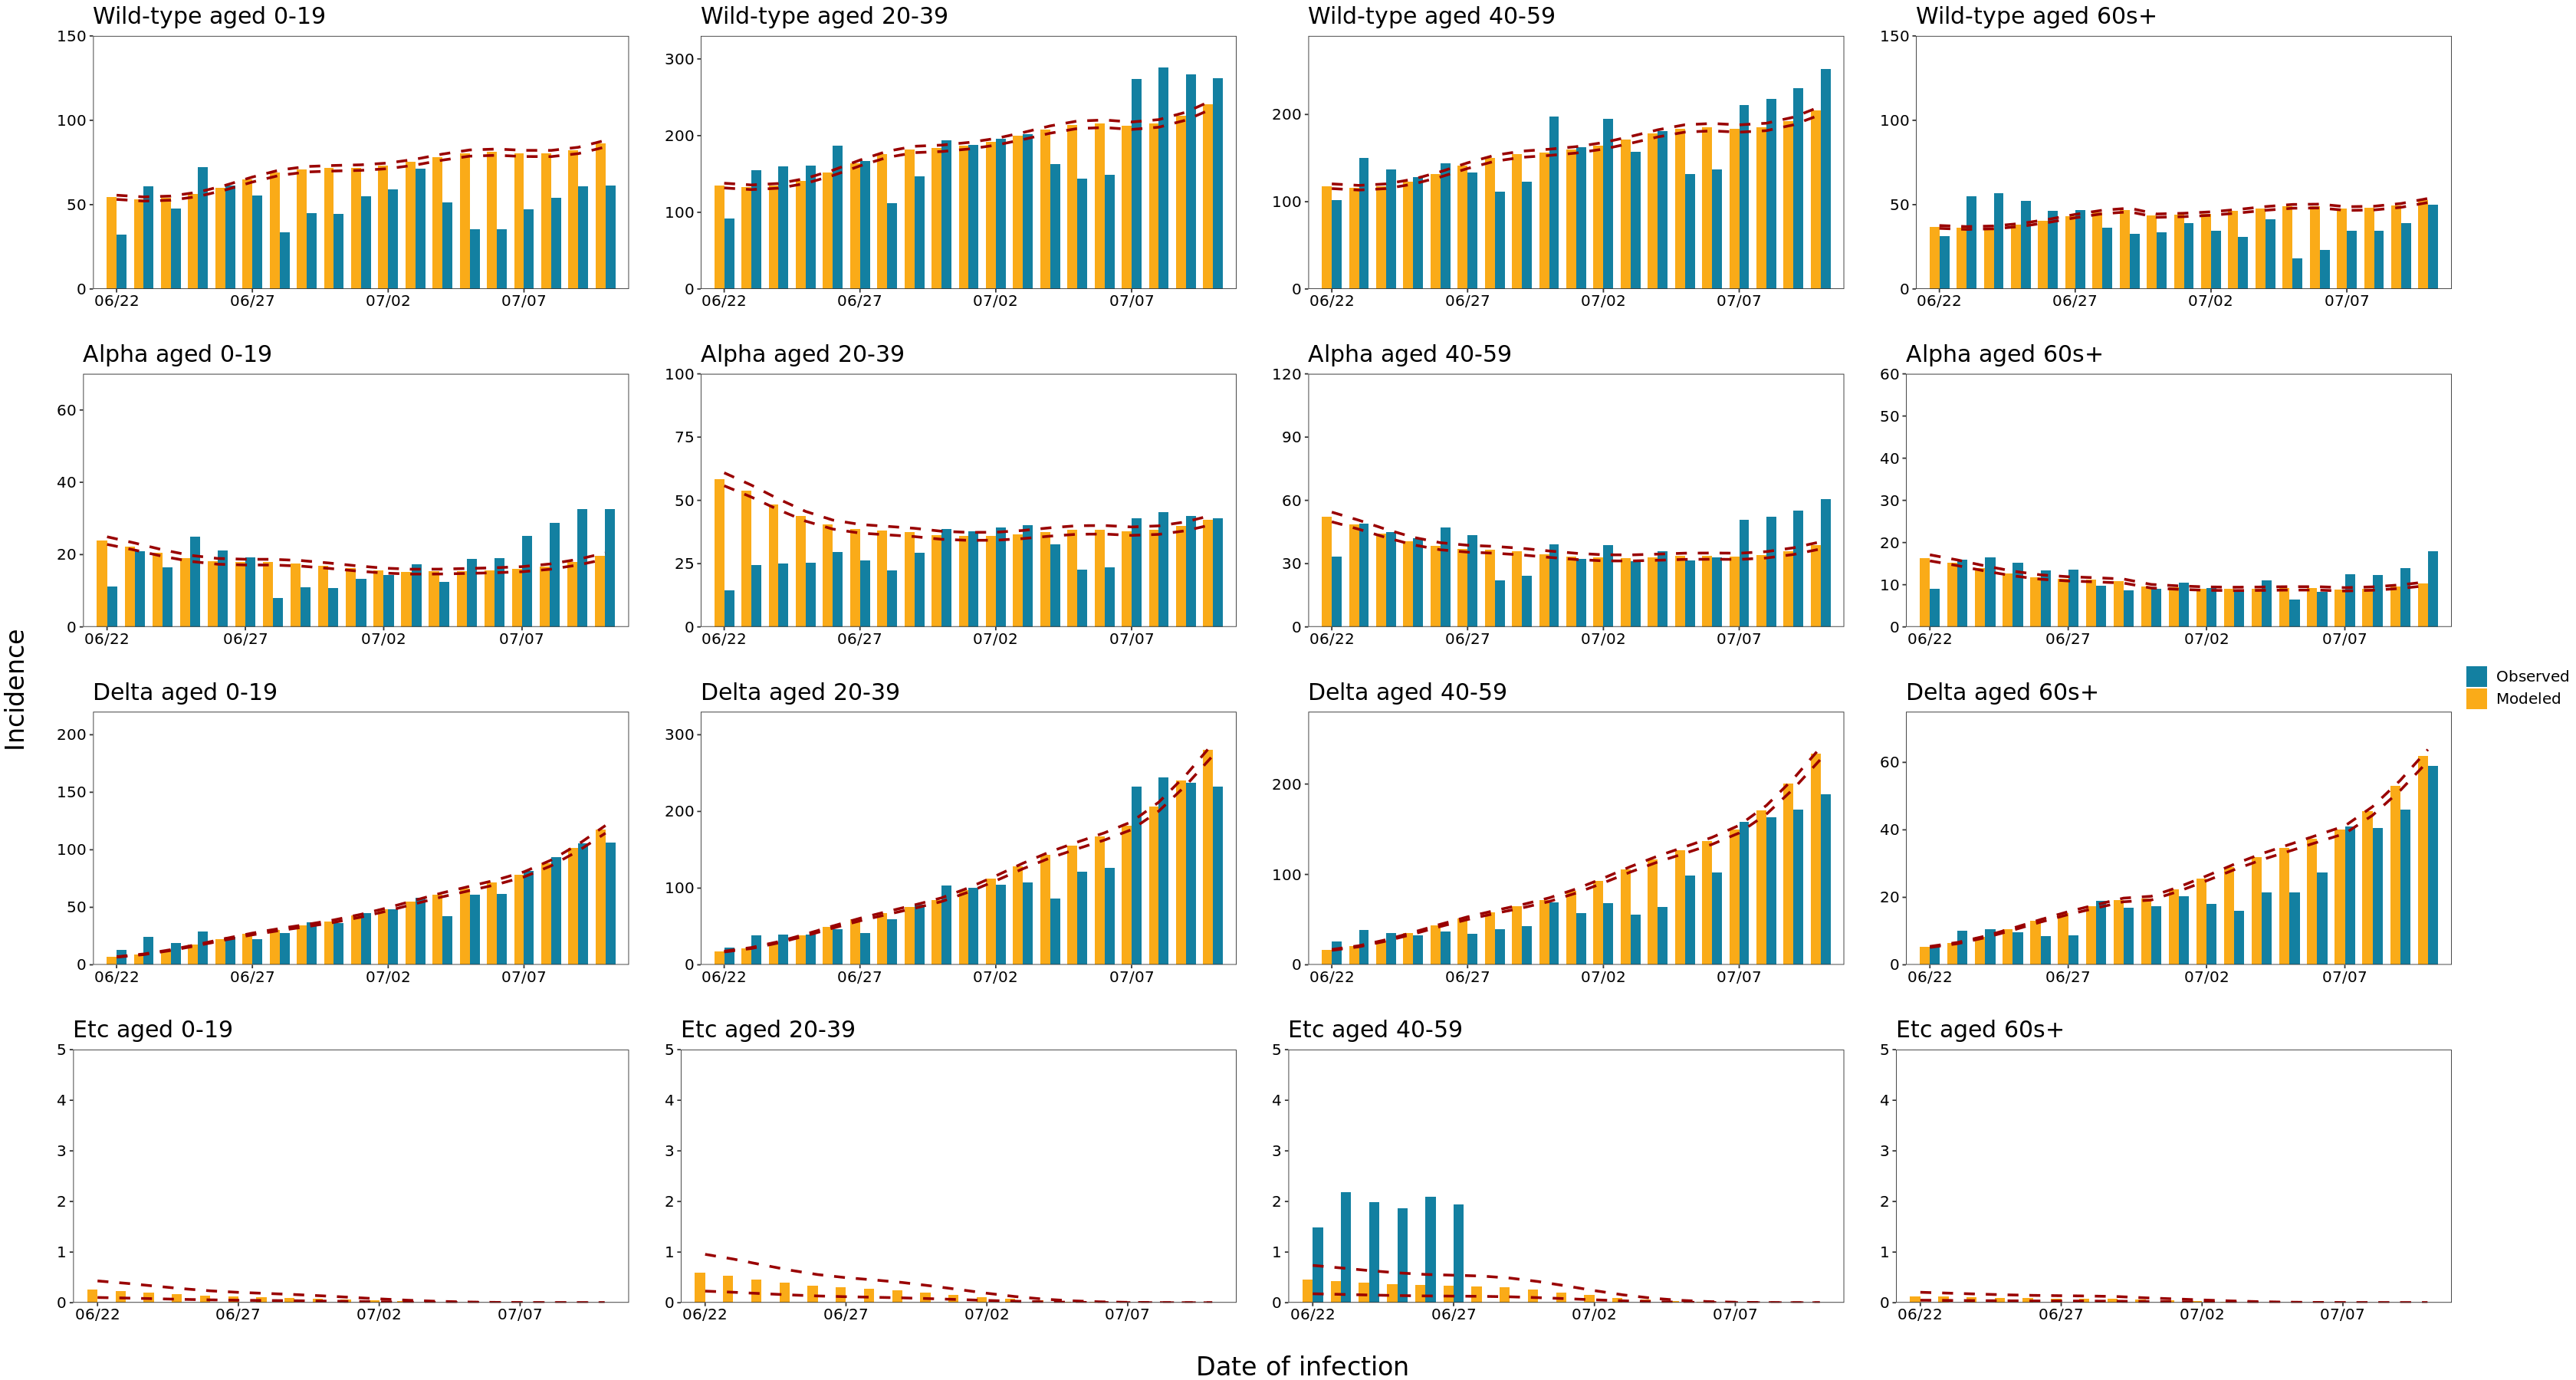

In [52]:
time_inter <- c("5 days")

fig_conv1 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Cs_bands, aes(x=date, y=lower_1), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Cs_bands, aes(x=date, y=upper_1), color="#990000", linetype = "dashed", size=1) +
ggtitle("Wild-type aged 0-19") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,150)) -> Fig_conv1

fig_conv2 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Cs_bands, aes(x=date, y=lower_2), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Cs_bands, aes(x=date, y=upper_2), color="#990000", linetype = "dashed", size=1) +
ggtitle("Wild-type aged 20-39") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,330)) -> Fig_conv2

fig_conv3 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Cs_bands, aes(x=date, y=lower_3), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Cs_bands, aes(x=date, y=upper_3), color="#990000", linetype = "dashed", size=1) +
ggtitle("Wild-type aged 40-59") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,290)) -> Fig_conv3

fig_conv4 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Cs_bands, aes(x=date, y=lower_4), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Cs_bands, aes(x=date, y=upper_4), color="#990000", linetype = "dashed", size=1) +
ggtitle("Wild-type aged 60s+") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,150)) -> Fig_conv4

fig_alpha1 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Alpha_bands, aes(x=date, y=lower_1), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Alpha_bands, aes(x=date, y=upper_1), color="#990000", linetype = "dashed", size=1) +
ggtitle("Alpha aged 0-19") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,70)) -> Fig_alpha1

fig_alpha2 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Alpha_bands, aes(x=date, y=lower_2), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Alpha_bands, aes(x=date, y=upper_2), color="#990000", linetype = "dashed", size=1) +
ggtitle("Alpha aged 20-39") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,100)) -> Fig_alpha2

fig_alpha3 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Alpha_bands, aes(x=date, y=lower_3), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Alpha_bands, aes(x=date, y=upper_3), color="#990000", linetype = "dashed", size=1) +
ggtitle("Alpha aged 40-59") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,120)) -> Fig_alpha3

fig_alpha4 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Alpha_bands, aes(x=date, y=lower_4), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Alpha_bands, aes(x=date, y=upper_4), color="#990000", linetype = "dashed", size=1) +
ggtitle("Alpha aged 60s+") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,60)) -> Fig_alpha4

fig_delta1 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Delta_bands, aes(x=date, y=lower_1), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Delta_bands, aes(x=date, y=upper_1), color="#990000", linetype = "dashed", size=1) +
ggtitle("Delta aged 0-19") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,220)) -> Fig_delta1

fig_delta2 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Delta_bands, aes(x=date, y=lower_2), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Delta_bands, aes(x=date, y=upper_2), color="#990000", linetype = "dashed", size=1) +
ggtitle("Delta aged 20-39") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,330)) -> Fig_delta2

fig_delta3 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Delta_bands, aes(x=date, y=lower_3), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Delta_bands, aes(x=date, y=upper_3), color="#990000", linetype = "dashed", size=1) +
ggtitle("Delta aged 40-59") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,280)) -> Fig_delta3

fig_delta4 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Delta_bands, aes(x=date, y=lower_4), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Delta_bands, aes(x=date, y=upper_4), color="#990000", linetype = "dashed", size=1) +
ggtitle("Delta aged 60s+") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,75)) -> Fig_delta4

fig_etc1 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Etc_bands, aes(x=date, y=lower_1), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Etc_bands, aes(x=date, y=upper_1), color="#990000", linetype = "dashed", size=1) +
ggtitle("Etc aged 0-19") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,5)) -> Fig_etc1

fig_etc2 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Etc_bands, aes(x=date, y=lower_2), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Etc_bands, aes(x=date, y=upper_2), color="#990000", linetype = "dashed", size=1) +
ggtitle("Etc aged 20-39") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,5)) -> Fig_etc2

fig_etc3 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Etc_bands, aes(x=date, y=lower_3), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Etc_bands, aes(x=date, y=upper_3), color="#990000", linetype = "dashed", size=1) +
ggtitle("Etc aged 40-59") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,5)) -> Fig_etc3

fig_etc4 %>% 
ggplot() + 
geom_bar(aes(x=date, y=V1, fill=group, group=group), stat='identity', position = "dodge", width=0.73) +
scale_fill_manual("", values=c("#1380A1", "#FAAB18"), breaks=c('Observed','Modeled')) +
geom_line(data=Etc_bands, aes(x=date, y=lower_4), color="#990000", linetype = "dashed", size=1) +
geom_line(data=Etc_bands, aes(x=date, y=upper_4), color="#990000", linetype = "dashed", size=1) +
ggtitle("Etc aged 60s+") +
labs(x="", y="") +
theme(text = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=12, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 13),
      legend.text = element_text(size = 12)) +
scale_x_date(date_labels="%m/%d",date_breaks = time_inter, expand = c(0, 0.5)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,5)) -> Fig_etc4

options(repr.plot.width=28,repr.plot.height=15)
ggarrange(Fig_conv1, Fig_conv2, Fig_conv3, Fig_conv4,
          Fig_alpha1, Fig_alpha2, Fig_alpha3, Fig_alpha4,
          Fig_delta1, Fig_delta2, Fig_delta3, Fig_delta4,
          Fig_etc1, Fig_etc2, Fig_etc3, Fig_etc4,
          ncol = 4, nrow = 4, common.legend = TRUE, legend="right") -> Fig_temp

annotate_figure(Fig_temp, left=text_grob("Incidence", size=20, rot=90),
                bottom=text_grob("Date of infection", size=20, vjust=0.5))

ggsave("../figures/Fitting_varinats.tiff", width = 28, height = 15)

# 5. Simulation with the Korea setting

## 5-1. Scenarios & Parameters

In [53]:
#### duration of simulation
Start_date = as.Date("2021-08-02")
Inter_date = as.Date("2022-01-02")
Finish_date = as.Date("2023-06-01") ## 근데 5월 31일까지 나옴..

#### intervention
Counter_date = as.Date("2021-07-12")
Lift_date1 = as.Date("2021-11-01")

#### with corona
With_date1 <- Lift_date1 + 60

#### holiday effect
Holy_date1 = as.Date("2021-09-04")
Holy_date2 = as.Date("2021-09-18")
Holy_date3 = as.Date("2021-09-22")

#### transformation
counter_date = as.numeric(Counter_date-Start_date)+1
lift_date1 = as.numeric(Lift_date1-Start_date)+1
lift_dates <- c(lift_date1)

with_date1 = as.numeric(With_date1-Start_date)+1
with_dates <- c(with_date1)

holy_date1 = as.numeric(Holy_date1-Start_date)+1
holy_date2 = as.numeric(Holy_date2-Start_date)+1
holy_date3 = as.numeric(Holy_date3-Start_date)+1
holy_dates = c(holy_date1, holy_date2, holy_date3)

lgth <- as.numeric(Finish_date-Start_date)
week_inter <- as.numeric(Inter_date-Start_date)

In [54]:
#### Rt
R_base <- as.numeric(quantile(temp_R, 0.5)) ## estimated
Rt_counter = c(0.60) ## Rt with countermeasures + 0.005 (0.5%) increase every single week
(Rt_counter2 = c((0.60+(0.005*7)), 0.80, 0.90)) 
holiday_effects <- c(0, 0.1, 0.2)
Final_Rts = c(2.5, 2.75, 3.0, 3.5, 4.5)

[1] 0.635 0.800 0.900

In [55]:
#### vaccination
mRNA_ve = 0.88
AZ_ve = 0.66
JJ_ve = 0.3

H_ve = 0.95

read_excel("../data/vac_scenario2.xlsx", sheet="AZ", col_names=FALSE) -> AZ_vc
read_excel("../data/vac_scenario2.xlsx", sheet="JJ", col_names=FALSE) -> JJ_vc
read_excel("../data/vac_scenario2.xlsx", sheet="mRNA", col_names=FALSE) -> mRNA_vc

AZ_vc[rev(rownames(AZ_vc)), ] -> AZ_vc
JJ_vc[rev(rownames(JJ_vc)), ] -> JJ_vc
mRNA_vc[rev(rownames(mRNA_vc)), ] -> mRNA_vc

as.data.frame(AZ_vc %>% t()) %>% mutate(Week = 24:(ncol(AZ_vc)+23)) %>% filter(Week >= 30) -> diff_AZ_vc
cbind(as.data.frame(diff(diff_AZ_vc$V1)), as.data.frame(diff(diff_AZ_vc$V2)),
      as.data.frame(diff(diff_AZ_vc$V3)), as.data.frame(diff(diff_AZ_vc$V4))) -> diff_AZ_vc

as.data.frame(JJ_vc %>% t()) %>% mutate(Week = 24:(ncol(JJ_vc)+23)) %>% filter(Week >= 30) -> diff_JJ_vc
cbind(as.data.frame(diff(diff_JJ_vc$V1)), as.data.frame(diff(diff_JJ_vc$V2)),
      as.data.frame(diff(diff_JJ_vc$V3)), as.data.frame(diff(diff_JJ_vc$V4))) -> diff_JJ_vc

as.data.frame(mRNA_vc %>% t()) %>% mutate(Week = 24:(ncol(mRNA_vc)+23)) %>% filter(Week >= 30) -> diff_mRNA_vc
cbind(as.data.frame(diff(diff_mRNA_vc$V1)), as.data.frame(diff(diff_mRNA_vc$V2)),
      as.data.frame(diff(diff_mRNA_vc$V3)), as.data.frame(diff(diff_mRNA_vc$V4))) -> diff_mRNA_vc

colnames(diff_AZ_vc) <- c("diff_1","diff_2","diff_3","diff_4")
colnames(diff_JJ_vc) <- c("diff_1","diff_2","diff_3","diff_4")
colnames(diff_mRNA_vc) <- c("diff_1","diff_2","diff_3","diff_4")

diff_AZ_vc %<>% mutate(Week = 31:(nrow(diff_AZ_vc)+30)) 
diff_JJ_vc %<>% mutate(Week = 31:(nrow(diff_JJ_vc)+30))
diff_mRNA_vc %<>% mutate(Week = 31:(nrow(diff_mRNA_vc)+30)) 

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...

New names:
* `` -> ...1
* `` -> ...2
* `` -> ...3
* `` -> ...4
* `` -> ...5
* ...



In [56]:
#### initial values for R compartment
master_df %>% filter(Date <= Start_date) %>% 
dplyr::select(-Date) %>% colSums %>% as.vector() -> init_R ## cumulative number of reported cases

#### initial values for E and I compartments 
master_df %>% filter(Date == Start_date + time_delay-2) %>% 
dplyr::select(-Date) %>% colSums -> temp 
temp*3 -> init_E
temp*5 -> init_I

sum(init_E)
sum(init_I)

#### initial values for Sv compartment (vaccinated) 
as.data.frame(AZ_vc %>% t()) %>% mutate(Week = 24:(ncol(AZ_vc)+23)) %>% filter(Week ==30) -> temp_AZ
as.data.frame(JJ_vc %>% t()) %>% mutate(Week = 24:(ncol(JJ_vc)+23)) %>% filter(Week ==30) -> temp_JJ
as.data.frame(mRNA_vc %>% t()) %>% mutate(Week = 24:(ncol(mRNA_vc)+23)) %>% filter(Week ==30) -> temp_mRNA

(round(temp_AZ[1,-5]*popsize) -> init_Sv_AZ)
(round(temp_JJ[1,-5]*popsize) -> init_Sv_JJ)
(round(temp_mRNA[1,-5]*popsize) -> init_Sv_mRNA)

[1] 4473

[1] 7455

,V1,V2,V3,V4
,<dbl>,<dbl>,<dbl>,<dbl>
...1,0,629945,1846173,7521812


,V1,V2,V3,V4
,<dbl>,<dbl>,<dbl>,<dbl>
...1,0,758673,258464,64473


,V1,V2,V3,V4
,<dbl>,<dbl>,<dbl>,<dbl>
...1,0,1232501,1007004,3283331


## 5-2. Simulations for the forecasting

In [57]:
niter = 100

In [58]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

vac_case_final <- list(); vac_severe_final <- list(); vac_deaths_final <- list()
simul_results_list <- list()


simul_results_list <- foreach (k = 1:niter) %dopar% {
    
    param <- est_param_sample[k,]
    
    for (p in 1:length(Rt_counter2)){
        
        ############################################################
        ############################################################
        Rt_counters <- Rt_counter[1]+(0.005*3)  #### varying the reduction effect
        Rt_counters2 <- Rt_counter2[p]  #### varying the reduction effect
        
        holy_start <- holy_dates[1] #### 04 September  
        
        holy_start2 <- holy_dates[2] #### 04 September 
        holy_start3 <- holy_dates[3] #### 04 September 
        
        lift_start <- lift_dates[1] #### 01 November
        with_start <- with_dates[1] #### 01 November + 60 days
        
        final_Rt = Final_Rts[1] ##### Maximum Rt = 2.5
        
        holiday_effect = holiday_effects[1]
        ############################################################
        ############################################################
        
        #### fixed parameters
        epsilon = 1/3
        sigma = 1/5
        omega = 1/18
        IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
        SR <- c(0.001, 0.157, 1.071, 9.129)*0.01
        SR_np <- c(SR[1], SR[2:4]*(1-H_ve))

        lgth <- as.numeric(Finish_date-Start_date)
        llk_total <- rep(0, lgth)
    
        
        #### compartments 
        S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        S_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        E_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        H_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))        
        R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        eff_N = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        V_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        V_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))     
        V_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        
        #### rates 
        pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pSE_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        npV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_s = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H_total = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        
        #### initial conditions
        for (g in 1:ncol(init_value)){         
            
            S_np[1,g] <- init_Sv_AZ[g]*(1-AZ_ve) + init_Sv_JJ[g]*(1-JJ_ve) + init_Sv_mRNA[g]*(1-mRNA_ve)
            
            V_AZ[1,g] <- init_Sv_AZ[g]*AZ_ve
            V_JJ[1,g] <- init_Sv_JJ[g]*JJ_ve
            V_mRNA[1,g] <- init_Sv_mRNA[g]*mRNA_ve
            
            
            S[1,g] <- popsize[g] - (init_E[g] + init_I[g] + init_R[g] + S_np[1,g] +
                                    V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g])
            
            E[1,g] <- init_E[g]; I[1,g] <- init_I[g]
            E_np[1,g] <- 0; I_np[1,g] <- 0
            
            H[1,g] <- 0; H_np[1,g] <- 0;
            D[1,g] <- 0; R[1,g] <- init_R[g]
            
            pSE[1,g] <- 0; pSE_np[1,g] <- 0;
            
            pEI[1,g] <- 0; pEI_np[1,g] <- 0;
            pIR[1,g] <- 0; pIR_np[1,g] <- 0; pIH[1,g] <- 0; pIH_np[1,g] <- 0;    
            pHR[1,g] <- 0; pHD[1,g] <- 0; pHR_np[1,g] <- 0; pHD_np[1,g] <- 0
                 
            pV_AZ[1,g] <- 0; pV_JJ[1,g] <- 0; pV_mRNA[1,g] <- 0;
            npV_AZ[1,g] <- 0; npV_JJ[1,g] <- 0; npV_mRNA[1,g] <- 0;
            
            
            eff_N[1,g] = S[1,g] + S_np[1,g] + E[1,g] + I[1,g] + E_np[1,g] + I_np[1,g] + R[1,g] + 
                          V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g]
            
            Reported_modelled[1,g] <- 0
            Reported_modelled_s[1,g] <- 0
            Reported_modelled_np[1,g] <- 0
            H_total[1,g] <- 0
        }


        #### Dynamics in rates
        for (t in 2:lgth){
            
            for (g in 1:ncol(init_value)){                  
                                          
            #### period with the full countermeasures 
                if(t <= holy_start){
                    
                    t_mod <- as.integer((t-1)/7)
                    Rt_counters_mod <- Rt_counters+0.005*t_mod
                                    
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                
            #### period with 9/4 ~ 9/18
                else if(t > holy_start & t <= holy_start2){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }                
                    
                    
            #### period during holidays
                else if(t > holy_start2 & t <= holy_start3){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod + holiday_effect
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                    
                    #### period with the full countermeasures 
                else if(t > holy_start3 & t <= lift_start){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }
                
            #### logistic growth in the Rt 
                else if(t > lift_start & t <= with_start){
                    
                    ## logistic growth of Rt
                    t_fixed <- as.integer((lift_start-holy_start-1)/7)
                    param[5]*(Rt_counters2+0.005*t_fixed) -> x0
                    x0_temp <- 0.00000001
                    
                    phi_a = (final_Rt/(param[7]*R_base))/x0_temp-1
                    phi_b = log(phi_a)/30
                    phi_c = final_Rt/(param[7]*R_base)-x0
                    
                    mod <- phi_c/(1+phi_a*exp(-phi_b*(t-lift_start)))+x0                
                    

                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 
                } 
                   
               #### period "with corona"    
                else {                 
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))   
                }   
                    
                    
            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
                    
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
                    
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))
                    
                    
            pEI_np[t,g] <- E_np[t-1,g]*(1-exp(-epsilon))
                    
            pIR_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(1-SR_np[g])))
            pIH_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(SR_np[g])))
                
            pHD_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*(1-IFR[g])))
    
            
            #### Vaccination
            if(t<= week_inter){
            nVAC_AZ <- (diff_AZ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_JJ <- (diff_JJ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_mRNA <- (diff_mRNA_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7

            pV_AZ[t,g] <- nVAC_AZ*AZ_ve
            pV_JJ[t,g] <- nVAC_JJ*JJ_ve
            pV_mRNA[t,g] <- nVAC_mRNA*mRNA_ve
                
            npV_AZ[t,g] <- nVAC_AZ*(1-AZ_ve)
            npV_JJ[t,g] <- nVAC_JJ*(1-JJ_ve)
            npV_mRNA[t,g] <- nVAC_mRNA*(1-mRNA_ve)
            }
                
            else 
            {pV_AZ[t,g] <- 0
            pV_JJ[t,g] <- 0
            pV_mRNA[t,g] <- 0
                
            npV_AZ[t,g] <- 0
            npV_JJ[t,g] <- 0
            npV_mRNA[t,g] <- 0} 
                
                
            #### Dynamics in the model             
            S[t,g] <- S[t-1,g] - pSE[t,g] - pV_AZ[t,g] - pV_JJ[t,g] - pV_mRNA[t,g] - 
                      npV_AZ[t,g] - npV_JJ[t,g] - npV_mRNA[t,g]
            S_np[t,g] <- S_np[t-1,g] - pSE_np[t,g] + npV_AZ[t,g] + npV_JJ[t,g] + npV_mRNA[t,g]
                    
            V_AZ[t,g] <- V_AZ[t-1,g] + pV_AZ[t,g]
            V_JJ[t,g] <- V_JJ[t-1,g] + pV_JJ[t,g]        
            V_mRNA[t,g] <- V_mRNA[t-1,g] + pV_mRNA[t,g]        

            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g]
                
            E_np[t,g] <- E_np[t-1,g] + pSE_np[t,g] - pEI_np[t,g]
            I_np[t,g] <- I_np[t-1,g] + pEI_np[t,g] - pIH_np[t,g] - pIR_np[t,g] 
                
            I[,g][I[,g]<0] <- 0; I_np[,g][I_np[,g]<0] <- 0; 
                
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHR[t,g] - pHD[t,g]               
            H_np[t,g] <- H_np[t-1,g] + pIH_np[t,g] - pHR_np[t,g] - pHD_np[t,g] 
                
            D[t,g] <- D[t-1,g] + pHD[t,g] + pHD_np[t,g]    
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] + pHR_np[t,g] + pIR_np[t,g] 
                
            eff_N[t,g] <- S[t,g] + S_np[t,g] + E[t,g] + I[t,g] + E_np[t,g] + I_np[t,g] + R[t,g] + 
                          V_AZ[t,g] + V_JJ[t,g] + V_mRNA[t,g]
               
                
            #### the nubmer of reporting cases with the convolution
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_s[t,g]
                
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE_np[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_np[t,g]
            
            Reported_modelled_s[t,g]+Reported_modelled_np[t,g] -> Reported_modelled[t,g]
                
            H[t,g] + H_np[t,g] -> H_total[t,g]    
            } 
        }
        
        #### simulation results
        Reported_modelled -> vac_case_final[[p]]
        H_total -> vac_severe_final[[p]]
        D -> vac_deaths_final[[p]]
        
    }
                    
    list(vac_case_final, vac_severe_final, vac_deaths_final) -> simul_results_list[[k]]
}    

stopCluster(myCluster)
(proc.time()-time_org)

saveRDS(simul_results_list, "../result/rds/Korea_simulation_list_holiday1.rds")

    user   system  elapsed 
   2.316    0.234 9657.899 

In [59]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

vac_case_final <- list(); vac_severe_final <- list(); vac_deaths_final <- list()
simul_results_list <- list()


simul_results_list <- foreach (k = 1:niter) %dopar% {
    
    param <- est_param_sample[k,]
    
    for (p in 1:length(Rt_counter2)){
        
        ############################################################
        ############################################################
        Rt_counters <- Rt_counter[1]+(0.005*3)  #### varying the reduction effect
        Rt_counters2 <- Rt_counter2[p]  #### varying the reduction effect
        
        holy_start <- holy_dates[1] #### 04 September  
        
        holy_start2 <- holy_dates[2] #### 04 September 
        holy_start3 <- holy_dates[3] #### 04 September 
        
        lift_start <- lift_dates[1] #### 01 November
        with_start <- with_dates[1] #### 01 November + 60 days
        
        final_Rt = Final_Rts[2] ##### Maximum Rt = 2.75
        
        holiday_effect = holiday_effects[1]
        ############################################################
        ############################################################
        
        #### fixed parameters
        epsilon = 1/3
        sigma = 1/5
        omega = 1/18
        IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
        SR <- c(0.001, 0.157, 1.071, 9.129)*0.01
        SR_np <- c(SR[1], SR[2:4]*(1-H_ve))

        lgth <- as.numeric(Finish_date-Start_date)
        llk_total <- rep(0, lgth)
    
        
        #### compartments 
        S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        S_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        E_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        H_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))        
        R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        eff_N = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        V_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        V_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))     
        V_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        
        #### rates 
        pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pSE_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        npV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_s = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H_total = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        
        #### initial conditions
        for (g in 1:ncol(init_value)){         
            
            S_np[1,g] <- init_Sv_AZ[g]*(1-AZ_ve) + init_Sv_JJ[g]*(1-JJ_ve) + init_Sv_mRNA[g]*(1-mRNA_ve)
            
            V_AZ[1,g] <- init_Sv_AZ[g]*AZ_ve
            V_JJ[1,g] <- init_Sv_JJ[g]*JJ_ve
            V_mRNA[1,g] <- init_Sv_mRNA[g]*mRNA_ve
            
            
            S[1,g] <- popsize[g] - (init_E[g] + init_I[g] + init_R[g] + S_np[1,g] +
                                    V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g])
            
            E[1,g] <- init_E[g]; I[1,g] <- init_I[g]
            E_np[1,g] <- 0; I_np[1,g] <- 0
            
            H[1,g] <- 0; H_np[1,g] <- 0;
            D[1,g] <- 0; R[1,g] <- init_R[g]
            
            pSE[1,g] <- 0; pSE_np[1,g] <- 0;
            
            pEI[1,g] <- 0; pEI_np[1,g] <- 0;
            pIR[1,g] <- 0; pIR_np[1,g] <- 0; pIH[1,g] <- 0; pIH_np[1,g] <- 0;    
            pHR[1,g] <- 0; pHD[1,g] <- 0; pHR_np[1,g] <- 0; pHD_np[1,g] <- 0
                 
            pV_AZ[1,g] <- 0; pV_JJ[1,g] <- 0; pV_mRNA[1,g] <- 0;
            npV_AZ[1,g] <- 0; npV_JJ[1,g] <- 0; npV_mRNA[1,g] <- 0;
            
            
            eff_N[1,g] = S[1,g] + S_np[1,g] + E[1,g] + I[1,g] + E_np[1,g] + I_np[1,g] + R[1,g] + 
                          V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g]
            
            Reported_modelled[1,g] <- 0
            Reported_modelled_s[1,g] <- 0
            Reported_modelled_np[1,g] <- 0
            H_total[1,g] <- 0
        }


        #### Dynamics in rates
        for (t in 2:lgth){
            
            for (g in 1:ncol(init_value)){                  
                                          
            #### period with the full countermeasures 
                if(t <= holy_start){
                    
                    t_mod <- as.integer((t-1)/7)
                    Rt_counters_mod <- Rt_counters+0.005*t_mod
                                    
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                
            #### period with 9/4 ~ 9/18
                else if(t > holy_start & t <= holy_start2){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }                
                    
                    
            #### period during holidays
                else if(t > holy_start2 & t <= holy_start3){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod + holiday_effect
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                    
                    #### period with the full countermeasures 
                else if(t > holy_start3 & t <= lift_start){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }
                
            #### logistic growth in the Rt 
                else if(t > lift_start & t <= with_start){
                    
                    ## logistic growth of Rt
                    t_fixed <- as.integer((lift_start-holy_start-1)/7)
                    param[5]*(Rt_counters2+0.005*t_fixed) -> x0
                    x0_temp <- 0.00000001
                    
                    phi_a = (final_Rt/(param[7]*R_base))/x0_temp-1
                    phi_b = log(phi_a)/30
                    phi_c = final_Rt/(param[7]*R_base)-x0
                    
                    mod <- phi_c/(1+phi_a*exp(-phi_b*(t-lift_start)))+x0                
                    

                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 
                } 
                   
               #### period "with corona"    
                else {                 
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))   
                }   
                    
                    
            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
                    
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
                    
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))
                    
                    
            pEI_np[t,g] <- E_np[t-1,g]*(1-exp(-epsilon))
                    
            pIR_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(1-SR_np[g])))
            pIH_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(SR_np[g])))
                
            pHD_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*(1-IFR[g])))
    
            
            #### Vaccination
            if(t<= week_inter){
            nVAC_AZ <- (diff_AZ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_JJ <- (diff_JJ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_mRNA <- (diff_mRNA_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7

            pV_AZ[t,g] <- nVAC_AZ*AZ_ve
            pV_JJ[t,g] <- nVAC_JJ*JJ_ve
            pV_mRNA[t,g] <- nVAC_mRNA*mRNA_ve
                
            npV_AZ[t,g] <- nVAC_AZ*(1-AZ_ve)
            npV_JJ[t,g] <- nVAC_JJ*(1-JJ_ve)
            npV_mRNA[t,g] <- nVAC_mRNA*(1-mRNA_ve)
            }
                
            else 
            {pV_AZ[t,g] <- 0
            pV_JJ[t,g] <- 0
            pV_mRNA[t,g] <- 0
                
            npV_AZ[t,g] <- 0
            npV_JJ[t,g] <- 0
            npV_mRNA[t,g] <- 0} 
                
                
            #### Dynamics in the model             
            S[t,g] <- S[t-1,g] - pSE[t,g] - pV_AZ[t,g] - pV_JJ[t,g] - pV_mRNA[t,g] - 
                      npV_AZ[t,g] - npV_JJ[t,g] - npV_mRNA[t,g]
            S_np[t,g] <- S_np[t-1,g] - pSE_np[t,g] + npV_AZ[t,g] + npV_JJ[t,g] + npV_mRNA[t,g]
                    
            V_AZ[t,g] <- V_AZ[t-1,g] + pV_AZ[t,g]
            V_JJ[t,g] <- V_JJ[t-1,g] + pV_JJ[t,g]        
            V_mRNA[t,g] <- V_mRNA[t-1,g] + pV_mRNA[t,g]        

            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g]
                
            E_np[t,g] <- E_np[t-1,g] + pSE_np[t,g] - pEI_np[t,g]
            I_np[t,g] <- I_np[t-1,g] + pEI_np[t,g] - pIH_np[t,g] - pIR_np[t,g] 
                
            I[,g][I[,g]<0] <- 0; I_np[,g][I_np[,g]<0] <- 0; 
                
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHR[t,g] - pHD[t,g]               
            H_np[t,g] <- H_np[t-1,g] + pIH_np[t,g] - pHR_np[t,g] - pHD_np[t,g] 
                
            D[t,g] <- D[t-1,g] + pHD[t,g] + pHD_np[t,g]    
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] + pHR_np[t,g] + pIR_np[t,g] 
                
            eff_N[t,g] <- S[t,g] + S_np[t,g] + E[t,g] + I[t,g] + E_np[t,g] + I_np[t,g] + R[t,g] + 
                          V_AZ[t,g] + V_JJ[t,g] + V_mRNA[t,g]
               
                
            #### the nubmer of reporting cases with the convolution
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_s[t,g]
                
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE_np[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_np[t,g]
            
            Reported_modelled_s[t,g]+Reported_modelled_np[t,g] -> Reported_modelled[t,g]
                
            H[t,g] + H_np[t,g] -> H_total[t,g]    
            } 
        }
        
        #### simulation results
        Reported_modelled -> vac_case_final[[p]]
        H_total -> vac_severe_final[[p]]
        D -> vac_deaths_final[[p]]
        
    }
                    
    list(vac_case_final, vac_severe_final, vac_deaths_final) -> simul_results_list[[k]]
}    

stopCluster(myCluster)
(proc.time()-time_org)

saveRDS(simul_results_list, "../result/rds/Korea_simulation_list_holiday2.rds")

     user    system   elapsed 
    3.020     0.154 10586.820 

In [60]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

vac_case_final <- list(); vac_severe_final <- list(); vac_deaths_final <- list()
simul_results_list <- list()


simul_results_list <- foreach (k = 1:niter) %dopar% {
    
    param <- est_param_sample[k,]
    
    for (p in 1:length(Rt_counter2)){
        
        ############################################################
        ############################################################
        Rt_counters <- Rt_counter[1]+(0.005*3)  #### varying the reduction effect
        Rt_counters2 <- Rt_counter2[p]  #### varying the reduction effect
        
        holy_start <- holy_dates[1] #### 04 September  
        
        holy_start2 <- holy_dates[2] #### 04 September 
        holy_start3 <- holy_dates[3] #### 04 September 
        
        lift_start <- lift_dates[1] #### 01 November
        with_start <- with_dates[1] #### 01 November + 60 days
        
        final_Rt = Final_Rts[3] ##### Maximum Rt = 3.0
        
        holiday_effect = holiday_effects[1]
        ############################################################
        ############################################################
        
        #### fixed parameters
        epsilon = 1/3
        sigma = 1/5
        omega = 1/18
        IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
        SR <- c(0.001, 0.157, 1.071, 9.129)*0.01
        SR_np <- c(SR[1], SR[2:4]*(1-H_ve))

        lgth <- as.numeric(Finish_date-Start_date)
        llk_total <- rep(0, lgth)
    
        
        #### compartments 
        S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        S_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        E_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        H_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))        
        R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        eff_N = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        V_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        V_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))     
        V_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        
        #### rates 
        pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pSE_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        npV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_s = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H_total = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        
        #### initial conditions
        for (g in 1:ncol(init_value)){         
            
            S_np[1,g] <- init_Sv_AZ[g]*(1-AZ_ve) + init_Sv_JJ[g]*(1-JJ_ve) + init_Sv_mRNA[g]*(1-mRNA_ve)
            
            V_AZ[1,g] <- init_Sv_AZ[g]*AZ_ve
            V_JJ[1,g] <- init_Sv_JJ[g]*JJ_ve
            V_mRNA[1,g] <- init_Sv_mRNA[g]*mRNA_ve
            
            
            S[1,g] <- popsize[g] - (init_E[g] + init_I[g] + init_R[g] + S_np[1,g] +
                                    V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g])
            
            E[1,g] <- init_E[g]; I[1,g] <- init_I[g]
            E_np[1,g] <- 0; I_np[1,g] <- 0
            
            H[1,g] <- 0; H_np[1,g] <- 0;
            D[1,g] <- 0; R[1,g] <- init_R[g]
            
            pSE[1,g] <- 0; pSE_np[1,g] <- 0;
            
            pEI[1,g] <- 0; pEI_np[1,g] <- 0;
            pIR[1,g] <- 0; pIR_np[1,g] <- 0; pIH[1,g] <- 0; pIH_np[1,g] <- 0;    
            pHR[1,g] <- 0; pHD[1,g] <- 0; pHR_np[1,g] <- 0; pHD_np[1,g] <- 0
                 
            pV_AZ[1,g] <- 0; pV_JJ[1,g] <- 0; pV_mRNA[1,g] <- 0;
            npV_AZ[1,g] <- 0; npV_JJ[1,g] <- 0; npV_mRNA[1,g] <- 0;
            
            
            eff_N[1,g] = S[1,g] + S_np[1,g] + E[1,g] + I[1,g] + E_np[1,g] + I_np[1,g] + R[1,g] + 
                          V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g]
            
            Reported_modelled[1,g] <- 0
            Reported_modelled_s[1,g] <- 0
            Reported_modelled_np[1,g] <- 0
            H_total[1,g] <- 0
        }


        #### Dynamics in rates
        for (t in 2:lgth){
            
            for (g in 1:ncol(init_value)){                  
                                          
            #### period with the full countermeasures 
                if(t <= holy_start){
                    
                    t_mod <- as.integer((t-1)/7)
                    Rt_counters_mod <- Rt_counters+0.005*t_mod
                                    
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                
            #### period with 9/4 ~ 9/18
                else if(t > holy_start & t <= holy_start2){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }                
                    
                    
            #### period during holidays
                else if(t > holy_start2 & t <= holy_start3){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod + holiday_effect
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                    
                    #### period with the full countermeasures 
                else if(t > holy_start3 & t <= lift_start){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }
                
            #### logistic growth in the Rt 
                else if(t > lift_start & t <= with_start){
                    
                    ## logistic growth of Rt
                    t_fixed <- as.integer((lift_start-holy_start-1)/7)
                    param[5]*(Rt_counters2+0.005*t_fixed) -> x0
                    x0_temp <- 0.00000001
                    
                    phi_a = (final_Rt/(param[7]*R_base))/x0_temp-1
                    phi_b = log(phi_a)/30
                    phi_c = final_Rt/(param[7]*R_base)-x0
                    
                    mod <- phi_c/(1+phi_a*exp(-phi_b*(t-lift_start)))+x0                
                    

                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 
                } 
                   
               #### period "with corona"    
                else {                 
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))   
                }   
                    
                    
            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
                    
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
                    
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))
                    
                    
            pEI_np[t,g] <- E_np[t-1,g]*(1-exp(-epsilon))
                    
            pIR_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(1-SR_np[g])))
            pIH_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(SR_np[g])))
                
            pHD_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*(1-IFR[g])))
    
            
            #### Vaccination
            if(t<= week_inter){
            nVAC_AZ <- (diff_AZ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_JJ <- (diff_JJ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_mRNA <- (diff_mRNA_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7

            pV_AZ[t,g] <- nVAC_AZ*AZ_ve
            pV_JJ[t,g] <- nVAC_JJ*JJ_ve
            pV_mRNA[t,g] <- nVAC_mRNA*mRNA_ve
                
            npV_AZ[t,g] <- nVAC_AZ*(1-AZ_ve)
            npV_JJ[t,g] <- nVAC_JJ*(1-JJ_ve)
            npV_mRNA[t,g] <- nVAC_mRNA*(1-mRNA_ve)
            }
                
            else 
            {pV_AZ[t,g] <- 0
            pV_JJ[t,g] <- 0
            pV_mRNA[t,g] <- 0
                
            npV_AZ[t,g] <- 0
            npV_JJ[t,g] <- 0
            npV_mRNA[t,g] <- 0} 
                
                
            #### Dynamics in the model             
            S[t,g] <- S[t-1,g] - pSE[t,g] - pV_AZ[t,g] - pV_JJ[t,g] - pV_mRNA[t,g] - 
                      npV_AZ[t,g] - npV_JJ[t,g] - npV_mRNA[t,g]
            S_np[t,g] <- S_np[t-1,g] - pSE_np[t,g] + npV_AZ[t,g] + npV_JJ[t,g] + npV_mRNA[t,g]
                    
            V_AZ[t,g] <- V_AZ[t-1,g] + pV_AZ[t,g]
            V_JJ[t,g] <- V_JJ[t-1,g] + pV_JJ[t,g]        
            V_mRNA[t,g] <- V_mRNA[t-1,g] + pV_mRNA[t,g]        

            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g]
                
            E_np[t,g] <- E_np[t-1,g] + pSE_np[t,g] - pEI_np[t,g]
            I_np[t,g] <- I_np[t-1,g] + pEI_np[t,g] - pIH_np[t,g] - pIR_np[t,g] 
                
            I[,g][I[,g]<0] <- 0; I_np[,g][I_np[,g]<0] <- 0; 
                
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHR[t,g] - pHD[t,g]               
            H_np[t,g] <- H_np[t-1,g] + pIH_np[t,g] - pHR_np[t,g] - pHD_np[t,g] 
                
            D[t,g] <- D[t-1,g] + pHD[t,g] + pHD_np[t,g]    
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] + pHR_np[t,g] + pIR_np[t,g] 
                
            eff_N[t,g] <- S[t,g] + S_np[t,g] + E[t,g] + I[t,g] + E_np[t,g] + I_np[t,g] + R[t,g] + 
                          V_AZ[t,g] + V_JJ[t,g] + V_mRNA[t,g]
               
                
            #### the nubmer of reporting cases with the convolution
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_s[t,g]
                
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE_np[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_np[t,g]
            
            Reported_modelled_s[t,g]+Reported_modelled_np[t,g] -> Reported_modelled[t,g]
                
            H[t,g] + H_np[t,g] -> H_total[t,g]    
            } 
        }
        
        #### simulation results
        Reported_modelled -> vac_case_final[[p]]
        H_total -> vac_severe_final[[p]]
        D -> vac_deaths_final[[p]]
        
    }
                    
    list(vac_case_final, vac_severe_final, vac_deaths_final) -> simul_results_list[[k]]
}    

stopCluster(myCluster)
(proc.time()-time_org)

saveRDS(simul_results_list, "../result/rds/Korea_simulation_list_holiday3.rds")

     user    system   elapsed 
    3.163     0.278 10959.847 

In [61]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

vac_case_final <- list(); vac_severe_final <- list(); vac_deaths_final <- list()
simul_results_list <- list()


simul_results_list <- foreach (k = 1:niter) %dopar% {
    
    param <- est_param_sample[k,]
    
    for (p in 1:length(Rt_counter2)){
        
        ############################################################
        ############################################################
        Rt_counters <- Rt_counter[1]+(0.005*3)  #### varying the reduction effect
        Rt_counters2 <- Rt_counter2[p]  #### varying the reduction effect
        
        holy_start <- holy_dates[1] #### 04 September  
        
        holy_start2 <- holy_dates[2] #### 04 September 
        holy_start3 <- holy_dates[3] #### 04 September 
        
        lift_start <- lift_dates[1] #### 01 November
        with_start <- with_dates[1] #### 01 November + 60 days
        
        final_Rt = Final_Rts[4] ##### Maximum Rt = 3.5
        
        holiday_effect = holiday_effects[1]
        ############################################################
        ############################################################
        
        #### fixed parameters
        epsilon = 1/3
        sigma = 1/5
        omega = 1/18
        IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
        SR <- c(0.001, 0.157, 1.071, 9.129)*0.01
        SR_np <- c(SR[1], SR[2:4]*(1-H_ve))

        lgth <- as.numeric(Finish_date-Start_date)
        llk_total <- rep(0, lgth)
    
        
        #### compartments 
        S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        S_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        E_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        H_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))        
        R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        eff_N = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        V_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        V_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))     
        V_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        
        #### rates 
        pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pSE_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        npV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_s = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H_total = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        
        #### initial conditions
        for (g in 1:ncol(init_value)){         
            
            S_np[1,g] <- init_Sv_AZ[g]*(1-AZ_ve) + init_Sv_JJ[g]*(1-JJ_ve) + init_Sv_mRNA[g]*(1-mRNA_ve)
            
            V_AZ[1,g] <- init_Sv_AZ[g]*AZ_ve
            V_JJ[1,g] <- init_Sv_JJ[g]*JJ_ve
            V_mRNA[1,g] <- init_Sv_mRNA[g]*mRNA_ve
            
            
            S[1,g] <- popsize[g] - (init_E[g] + init_I[g] + init_R[g] + S_np[1,g] +
                                    V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g])
            
            E[1,g] <- init_E[g]; I[1,g] <- init_I[g]
            E_np[1,g] <- 0; I_np[1,g] <- 0
            
            H[1,g] <- 0; H_np[1,g] <- 0;
            D[1,g] <- 0; R[1,g] <- init_R[g]
            
            pSE[1,g] <- 0; pSE_np[1,g] <- 0;
            
            pEI[1,g] <- 0; pEI_np[1,g] <- 0;
            pIR[1,g] <- 0; pIR_np[1,g] <- 0; pIH[1,g] <- 0; pIH_np[1,g] <- 0;    
            pHR[1,g] <- 0; pHD[1,g] <- 0; pHR_np[1,g] <- 0; pHD_np[1,g] <- 0
                 
            pV_AZ[1,g] <- 0; pV_JJ[1,g] <- 0; pV_mRNA[1,g] <- 0;
            npV_AZ[1,g] <- 0; npV_JJ[1,g] <- 0; npV_mRNA[1,g] <- 0;
            
            
            eff_N[1,g] = S[1,g] + S_np[1,g] + E[1,g] + I[1,g] + E_np[1,g] + I_np[1,g] + R[1,g] + 
                          V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g]
            
            Reported_modelled[1,g] <- 0
            Reported_modelled_s[1,g] <- 0
            Reported_modelled_np[1,g] <- 0
            H_total[1,g] <- 0
        }


        #### Dynamics in rates
        for (t in 2:lgth){
            
            for (g in 1:ncol(init_value)){                  
                                          
            #### period with the full countermeasures 
                if(t <= holy_start){
                    
                    t_mod <- as.integer((t-1)/7)
                    Rt_counters_mod <- Rt_counters+0.005*t_mod
                                    
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                
            #### period with 9/4 ~ 9/18
                else if(t > holy_start & t <= holy_start2){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }                
                    
                    
            #### period during holidays
                else if(t > holy_start2 & t <= holy_start3){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod + holiday_effect
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                    
                    #### period with the full countermeasures 
                else if(t > holy_start3 & t <= lift_start){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }
                
            #### logistic growth in the Rt 
                else if(t > lift_start & t <= with_start){
                    
                    ## logistic growth of Rt
                    t_fixed <- as.integer((lift_start-holy_start-1)/7)
                    param[5]*(Rt_counters2+0.005*t_fixed) -> x0
                    x0_temp <- 0.00000001
                    
                    phi_a = (final_Rt/(param[7]*R_base))/x0_temp-1
                    phi_b = log(phi_a)/30
                    phi_c = final_Rt/(param[7]*R_base)-x0
                    
                    mod <- phi_c/(1+phi_a*exp(-phi_b*(t-lift_start)))+x0                
                    

                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 
                } 
                   
               #### period "with corona"    
                else {                 
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))   
                }   
                    
                    
            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
                    
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
                    
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))
                    
                    
            pEI_np[t,g] <- E_np[t-1,g]*(1-exp(-epsilon))
                    
            pIR_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(1-SR_np[g])))
            pIH_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(SR_np[g])))
                
            pHD_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*(1-IFR[g])))
    
            
            #### Vaccination
            if(t<= week_inter){
            nVAC_AZ <- (diff_AZ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_JJ <- (diff_JJ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_mRNA <- (diff_mRNA_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7

            pV_AZ[t,g] <- nVAC_AZ*AZ_ve
            pV_JJ[t,g] <- nVAC_JJ*JJ_ve
            pV_mRNA[t,g] <- nVAC_mRNA*mRNA_ve
                
            npV_AZ[t,g] <- nVAC_AZ*(1-AZ_ve)
            npV_JJ[t,g] <- nVAC_JJ*(1-JJ_ve)
            npV_mRNA[t,g] <- nVAC_mRNA*(1-mRNA_ve)
            }
                
            else 
            {pV_AZ[t,g] <- 0
            pV_JJ[t,g] <- 0
            pV_mRNA[t,g] <- 0
                
            npV_AZ[t,g] <- 0
            npV_JJ[t,g] <- 0
            npV_mRNA[t,g] <- 0} 
                
                
            #### Dynamics in the model             
            S[t,g] <- S[t-1,g] - pSE[t,g] - pV_AZ[t,g] - pV_JJ[t,g] - pV_mRNA[t,g] - 
                      npV_AZ[t,g] - npV_JJ[t,g] - npV_mRNA[t,g]
            S_np[t,g] <- S_np[t-1,g] - pSE_np[t,g] + npV_AZ[t,g] + npV_JJ[t,g] + npV_mRNA[t,g]
                    
            V_AZ[t,g] <- V_AZ[t-1,g] + pV_AZ[t,g]
            V_JJ[t,g] <- V_JJ[t-1,g] + pV_JJ[t,g]        
            V_mRNA[t,g] <- V_mRNA[t-1,g] + pV_mRNA[t,g]        

            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g]
                
            E_np[t,g] <- E_np[t-1,g] + pSE_np[t,g] - pEI_np[t,g]
            I_np[t,g] <- I_np[t-1,g] + pEI_np[t,g] - pIH_np[t,g] - pIR_np[t,g] 
                
            I[,g][I[,g]<0] <- 0; I_np[,g][I_np[,g]<0] <- 0; 
                
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHR[t,g] - pHD[t,g]               
            H_np[t,g] <- H_np[t-1,g] + pIH_np[t,g] - pHR_np[t,g] - pHD_np[t,g] 
                
            D[t,g] <- D[t-1,g] + pHD[t,g] + pHD_np[t,g]    
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] + pHR_np[t,g] + pIR_np[t,g] 
                
            eff_N[t,g] <- S[t,g] + S_np[t,g] + E[t,g] + I[t,g] + E_np[t,g] + I_np[t,g] + R[t,g] + 
                          V_AZ[t,g] + V_JJ[t,g] + V_mRNA[t,g]
               
                
            #### the nubmer of reporting cases with the convolution
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_s[t,g]
                
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE_np[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_np[t,g]
            
            Reported_modelled_s[t,g]+Reported_modelled_np[t,g] -> Reported_modelled[t,g]
                
            H[t,g] + H_np[t,g] -> H_total[t,g]    
            } 
        }
        
        #### simulation results
        Reported_modelled -> vac_case_final[[p]]
        H_total -> vac_severe_final[[p]]
        D -> vac_deaths_final[[p]]
        
    }
                    
    list(vac_case_final, vac_severe_final, vac_deaths_final) -> simul_results_list[[k]]
}    

stopCluster(myCluster)
(proc.time()-time_org)

saveRDS(simul_results_list, "../result/rds/Korea_simulation_list_holiday4.rds")

    user   system  elapsed 
   3.766    0.148 9732.697 

In [62]:
myCluster <- makeCluster(ncore-1, type = "PSOCK")
registerDoParallel(myCluster)

time_org <- proc.time()

vac_case_final <- list(); vac_severe_final <- list(); vac_deaths_final <- list()
simul_results_list <- list()


simul_results_list <- foreach (k = 1:niter) %dopar% {
    
    param <- est_param_sample[k,]
    
    for (p in 1:length(Rt_counter2)){
        
        ############################################################
        ############################################################
        Rt_counters <- Rt_counter[1]+(0.005*3)  #### varying the reduction effect
        Rt_counters2 <- Rt_counter2[p]  #### varying the reduction effect
        
        holy_start <- holy_dates[1] #### 04 September  
        
        holy_start2 <- holy_dates[2] #### 04 September 
        holy_start3 <- holy_dates[3] #### 04 September 
        
        lift_start <- lift_dates[1] #### 01 November
        with_start <- with_dates[1] #### 01 November + 60 days
        
        final_Rt = Final_Rts[5] ##### Maximum Rt = 4.5
        
        holiday_effect = holiday_effects[1]
        ############################################################
        ############################################################
        
        #### fixed parameters
        epsilon = 1/3
        sigma = 1/5
        omega = 1/18
        IFR <- opt_FR$par; IFR[1] <- c(0.001*0.01)
        SR <- c(0.001, 0.157, 1.071, 9.129)*0.01
        SR_np <- c(SR[1], SR[2:4]*(1-H_ve))

        lgth <- as.numeric(Finish_date-Start_date)
        llk_total <- rep(0, lgth)
    
        
        #### compartments 
        S = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        S_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        E = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        E_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        I_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        H_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        D = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))        
        R = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        eff_N = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        V_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        V_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))     
        V_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        
        #### rates 
        pSE = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pSE_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pEI_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pIH_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pHR_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pHD_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        pV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        pV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        npV_AZ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_JJ = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        npV_mRNA = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        Reported_modelled = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_s = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        Reported_modelled_np = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth))
        
        H_total = data.frame(matrix(NA, ncol=ncol(init_value), nrow=lgth)) 
        
        
        #### initial conditions
        for (g in 1:ncol(init_value)){         
            
            S_np[1,g] <- init_Sv_AZ[g]*(1-AZ_ve) + init_Sv_JJ[g]*(1-JJ_ve) + init_Sv_mRNA[g]*(1-mRNA_ve)
            
            V_AZ[1,g] <- init_Sv_AZ[g]*AZ_ve
            V_JJ[1,g] <- init_Sv_JJ[g]*JJ_ve
            V_mRNA[1,g] <- init_Sv_mRNA[g]*mRNA_ve
            
            
            S[1,g] <- popsize[g] - (init_E[g] + init_I[g] + init_R[g] + S_np[1,g] +
                                    V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g])
            
            E[1,g] <- init_E[g]; I[1,g] <- init_I[g]
            E_np[1,g] <- 0; I_np[1,g] <- 0
            
            H[1,g] <- 0; H_np[1,g] <- 0;
            D[1,g] <- 0; R[1,g] <- init_R[g]
            
            pSE[1,g] <- 0; pSE_np[1,g] <- 0;
            
            pEI[1,g] <- 0; pEI_np[1,g] <- 0;
            pIR[1,g] <- 0; pIR_np[1,g] <- 0; pIH[1,g] <- 0; pIH_np[1,g] <- 0;    
            pHR[1,g] <- 0; pHD[1,g] <- 0; pHR_np[1,g] <- 0; pHD_np[1,g] <- 0
                 
            pV_AZ[1,g] <- 0; pV_JJ[1,g] <- 0; pV_mRNA[1,g] <- 0;
            npV_AZ[1,g] <- 0; npV_JJ[1,g] <- 0; npV_mRNA[1,g] <- 0;
            
            
            eff_N[1,g] = S[1,g] + S_np[1,g] + E[1,g] + I[1,g] + E_np[1,g] + I_np[1,g] + R[1,g] + 
                          V_AZ[1,g] + V_JJ[1,g] + V_mRNA[1,g]
            
            Reported_modelled[1,g] <- 0
            Reported_modelled_s[1,g] <- 0
            Reported_modelled_np[1,g] <- 0
            H_total[1,g] <- 0
        }


        #### Dynamics in rates
        for (t in 2:lgth){
            
            for (g in 1:ncol(init_value)){                  
                                          
            #### period with the full countermeasures 
                if(t <= holy_start){
                    
                    t_mod <- as.integer((t-1)/7)
                    Rt_counters_mod <- Rt_counters+0.005*t_mod
                                    
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                
            #### period with 9/4 ~ 9/18
                else if(t > holy_start & t <= holy_start2){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }                
                    
                    
            #### period during holidays
                else if(t > holy_start2 & t <= holy_start3){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod + holiday_effect
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                } 
                    
                    #### period with the full countermeasures 
                else if(t > holy_start3 & t <= lift_start){
                    
                    t_mod <- as.integer((t-holy_start)/7)
                    Rt_counters_mod <- Rt_counters2+0.005*t_mod
                                       
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[5]*param[7]*Rt_counters_mod*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))  
                }
                
            #### logistic growth in the Rt 
                else if(t > lift_start & t <= with_start){
                    
                    ## logistic growth of Rt
                    t_fixed <- as.integer((lift_start-holy_start-1)/7)
                    param[5]*(Rt_counters2+0.005*t_fixed) -> x0
                    x0_temp <- 0.00000001
                    
                    phi_a = (final_Rt/(param[7]*R_base))/x0_temp-1
                    phi_b = log(phi_a)/30
                    phi_c = final_Rt/(param[7]*R_base)-x0
                    
                    mod <- phi_c/(1+phi_a*exp(-phi_b*(t-lift_start)))+x0                
                    

                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                
                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*mod*param[7]*(
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 
                } 
                   
               #### period "with corona"    
                else {                 
                    pSE[t,g] <- S[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4])))) 

                    pSE_np[t,g] <- S_np[t-1,g]*(1-exp(-(param[g]*param[7]*final_Rt/(param[7]*R_base)*(                        
                    adj_contact[g,1]*(I[t-1,1]+I_np[t-1,1])/eff_N[t-1,1] + 
                    adj_contact[g,2]*(I[t-1,2]+I_np[t-1,2])/eff_N[t-1,2] +
                    adj_contact[g,3]*(I[t-1,3]+I_np[t-1,3])/eff_N[t-1,3] +
                    adj_contact[g,4]*(I[t-1,4]+I_np[t-1,4])/eff_N[t-1,4]))))   
                }   
                    
                    
            pEI[t,g] <- E[t-1,g]*(1-exp(-epsilon))
                    
            pIR[t,g] <- I[t-1,g]*(1-exp(-sigma*(1-SR[g])))
            pIH[t,g] <- I[t-1,g]*(1-exp(-sigma*(SR[g])))
                    
            pHD[t,g] <- H[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR[t,g] <- H[t-1,g]*(1-exp(-omega*(1-IFR[g])))
                    
                    
            pEI_np[t,g] <- E_np[t-1,g]*(1-exp(-epsilon))
                    
            pIR_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(1-SR_np[g])))
            pIH_np[t,g] <- I_np[t-1,g]*(1-exp(-sigma*(SR_np[g])))
                
            pHD_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*IFR[g]))
            pHR_np[t,g] <- H_np[t-1,g]*(1-exp(-omega*(1-IFR[g])))
    
            
            #### Vaccination
            if(t<= week_inter){
            nVAC_AZ <- (diff_AZ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_JJ <- (diff_JJ_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7
            nVAC_mRNA <- (diff_mRNA_vc[(as.numeric(strftime(Start_date+t, "%V"))-30),g]*popsize[g])/7

            pV_AZ[t,g] <- nVAC_AZ*AZ_ve
            pV_JJ[t,g] <- nVAC_JJ*JJ_ve
            pV_mRNA[t,g] <- nVAC_mRNA*mRNA_ve
                
            npV_AZ[t,g] <- nVAC_AZ*(1-AZ_ve)
            npV_JJ[t,g] <- nVAC_JJ*(1-JJ_ve)
            npV_mRNA[t,g] <- nVAC_mRNA*(1-mRNA_ve)
            }
                
            else 
            {pV_AZ[t,g] <- 0
            pV_JJ[t,g] <- 0
            pV_mRNA[t,g] <- 0
                
            npV_AZ[t,g] <- 0
            npV_JJ[t,g] <- 0
            npV_mRNA[t,g] <- 0} 
                
                
            #### Dynamics in the model             
            S[t,g] <- S[t-1,g] - pSE[t,g] - pV_AZ[t,g] - pV_JJ[t,g] - pV_mRNA[t,g] - 
                      npV_AZ[t,g] - npV_JJ[t,g] - npV_mRNA[t,g]
            S_np[t,g] <- S_np[t-1,g] - pSE_np[t,g] + npV_AZ[t,g] + npV_JJ[t,g] + npV_mRNA[t,g]
                    
            V_AZ[t,g] <- V_AZ[t-1,g] + pV_AZ[t,g]
            V_JJ[t,g] <- V_JJ[t-1,g] + pV_JJ[t,g]        
            V_mRNA[t,g] <- V_mRNA[t-1,g] + pV_mRNA[t,g]        

            E[t,g] <- E[t-1,g] + pSE[t,g] - pEI[t,g]
            I[t,g] <- I[t-1,g] + pEI[t,g] - pIH[t,g] - pIR[t,g]
                
            E_np[t,g] <- E_np[t-1,g] + pSE_np[t,g] - pEI_np[t,g]
            I_np[t,g] <- I_np[t-1,g] + pEI_np[t,g] - pIH_np[t,g] - pIR_np[t,g] 
                
            I[,g][I[,g]<0] <- 0; I_np[,g][I_np[,g]<0] <- 0; 
                
            H[t,g] <- H[t-1,g] + pIH[t,g] - pHR[t,g] - pHD[t,g]               
            H_np[t,g] <- H_np[t-1,g] + pIH_np[t,g] - pHR_np[t,g] - pHD_np[t,g] 
                
            D[t,g] <- D[t-1,g] + pHD[t,g] + pHD_np[t,g]    
            R[t,g] <- R[t-1,g] + pHR[t,g] + pIR[t,g] + pHR_np[t,g] + pIR_np[t,g] 
                
            eff_N[t,g] <- S[t,g] + S_np[t,g] + E[t,g] + I[t,g] + E_np[t,g] + I_np[t,g] + R[t,g] + 
                          V_AZ[t,g] + V_JJ[t,g] + V_mRNA[t,g]
               
                
            #### the nubmer of reporting cases with the convolution
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_s[t,g]
                
            Report <- data.frame(matrix(0, ncol=ncol(init_value), nrow=t))  
            for (tau in 1:(t-1)){Report[tau,g] = (pSE_np[t-tau+1,g])*infectiontoreport(tau)[tau]}   
            sum(Report[,g]) -> Reported_modelled_np[t,g]
            
            Reported_modelled_s[t,g]+Reported_modelled_np[t,g] -> Reported_modelled[t,g]
                
            H[t,g] + H_np[t,g] -> H_total[t,g]    
            } 
        }
        
        #### simulation results
        Reported_modelled -> vac_case_final[[p]]
        H_total -> vac_severe_final[[p]]
        D -> vac_deaths_final[[p]]
        
    }
                    
    list(vac_case_final, vac_severe_final, vac_deaths_final) -> simul_results_list[[k]]
}    

stopCluster(myCluster)
(proc.time()-time_org)

saveRDS(simul_results_list, "../result/rds/Korea_simulation_list_holiday5.rds")

    user   system  elapsed 
   2.959    0.208 9785.127 

In [63]:
readRDS("../result/rds/Korea_simulation_list_holiday1.rds") -> simul_results_list
readRDS("../result/rds/Korea_simulation_list_holiday2.rds") -> simul_results_list2
readRDS("../result/rds/Korea_simulation_list_holiday3.rds") -> simul_results_list3
readRDS("../result/rds/Korea_simulation_list_holiday4.rds") -> simul_results_list4
readRDS("../result/rds/Korea_simulation_list_holiday5.rds") -> simul_results_list5
result_list <- list(simul_results_list, simul_results_list2, simul_results_list3, 
                    simul_results_list4, simul_results_list5)

In [64]:
final_list <-list()

for (w in 1:length(result_list)){
    simul_results_list <- result_list[[w]]


#### g = nVAC
#### newly infected cases
opti = 1
temp <- list()

for (g in 1:length(Rt_counter2)){
    temp_base <- as.data.frame(simul_results_list[[1]][[opti]][g])
    for(k in 2:niter){cbind(temp_base, as.data.frame(simul_results_list[[k]][[opti]][g])) -> temp_base}
    temp_base -> temp[[g]]}

temp_X1_list <- list(); temp_X2_list <- list(); temp_X3_list <- list(); temp_X4_list <- list()

for (g in 1:length(Rt_counter2)){
    m=1; as.matrix(temp[[g]][,1+4*(m-1)]) -> temp_X1
    for (m in 2:niter){as.matrix(temp[[g]][,1+4*(m-1)]) -> temp_X
                       cbind(temp_X1, temp_X) -> temp_X1}   

    m=1; as.matrix(temp[[g]][,2+4*(m-1)]) -> temp_X2
    for (m in 2:niter){as.matrix(temp[[g]][,2+4*(m-1)]) -> temp_X
                       cbind(temp_X2, temp_X) -> temp_X2}   

    m=1; as.matrix(temp[[g]][,3+4*(m-1)]) -> temp_X3
    for (m in 2:niter){as.matrix(temp[[g]][,3+4*(m-1)]) -> temp_X
                       cbind(temp_X3, temp_X) -> temp_X3}  

    m=1; as.matrix(temp[[g]][,4+4*(m-1)]) -> temp_X4
    for (m in 2:niter){as.matrix(temp[[g]][,4+4*(m-1)]) -> temp_X
                       cbind(temp_X4, temp_X) -> temp_X4}
    
    final_CI_X1 <- matrix(NA, nrow=nrow(temp_X1), ncol=3)
    final_CI_X2 <- matrix(NA, nrow=nrow(temp_X2), ncol=3)
    final_CI_X3 <- matrix(NA, nrow=nrow(temp_X3), ncol=3)
    final_CI_X4 <- matrix(NA, nrow=nrow(temp_X4), ncol=3)

    for (k in 1:nrow(temp_X1)){
        quantile(unlist(temp_X1[k,]), 0.025) -> final_CI_X1[k,2]
        quantile(unlist(temp_X1[k,]), 0.5) -> final_CI_X1[k,1]
        quantile(unlist(temp_X1[k,]), 0.975) -> final_CI_X1[k,3]}
    
    for (k in 1:nrow(temp_X2)){
        quantile(unlist(temp_X2[k,]), 0.025) -> final_CI_X2[k,2]
        quantile(unlist(temp_X2[k,]), 0.5) -> final_CI_X2[k,1]
        quantile(unlist(temp_X2[k,]), 0.975) -> final_CI_X2[k,3]}    
    
    for (k in 1:nrow(temp_X3)){
        quantile(unlist(temp_X3[k,]), 0.025) -> final_CI_X3[k,2]
        quantile(unlist(temp_X3[k,]), 0.5) -> final_CI_X3[k,1]
        quantile(unlist(temp_X3[k,]), 0.975) -> final_CI_X3[k,3]}
    
    for (k in 1:nrow(temp_X4)){
        quantile(unlist(temp_X4[k,]), 0.025) -> final_CI_X4[k,2]
        quantile(unlist(temp_X4[k,]), 0.5) -> final_CI_X4[k,1]
        quantile(unlist(temp_X4[k,]), 0.975) -> final_CI_X4[k,3]}
    
    final_CI_X1 -> temp_X1_list[[g]]; final_CI_X2 -> temp_X2_list[[g]] 
    final_CI_X3 -> temp_X3_list[[g]]; final_CI_X4 -> temp_X4_list[[g]]
}

g=1
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt60_case_med

temp_X1_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_case_CI_1; 
temp_X2_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_case_CI_2
temp_X3_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_case_CI_3; 
temp_X4_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_case_CI_4

g=2
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt70_case_med

temp_X1_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_case_CI_1; 
temp_X2_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_case_CI_2
temp_X3_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_case_CI_3; 
temp_X4_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_case_CI_4

g=3
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt80_case_med

temp_X1_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt80_case_CI_1; 
temp_X2_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_case_CI_2
temp_X3_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_case_CI_3; 
temp_X4_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_case_CI_4

  

#### g = nVAC
#### prevalence of severe cases
opti = 2
temp <- list()

for (g in 1:length(Rt_counter2)){
    temp_base <- as.data.frame(simul_results_list[[1]][[opti]][g])
    for(k in 2:niter){cbind(temp_base, as.data.frame(simul_results_list[[k]][[opti]][g])) -> temp_base}
    temp_base -> temp[[g]]}


temp_X1_list <- list(); temp_X2_list <- list(); temp_X3_list <- list(); temp_X4_list <- list()

for (g in 1:length(Rt_counter2)){
    m=1; as.matrix(temp[[g]][,1+4*(m-1)]) -> temp_X1
    for (m in 2:niter){as.matrix(temp[[g]][,1+4*(m-1)]) -> temp_X
                       cbind(temp_X1, temp_X) -> temp_X1}   

    m=1; as.matrix(temp[[g]][,2+4*(m-1)]) -> temp_X2
    for (m in 2:niter){as.matrix(temp[[g]][,2+4*(m-1)]) -> temp_X
                       cbind(temp_X2, temp_X) -> temp_X2}   

    m=1; as.matrix(temp[[g]][,3+4*(m-1)]) -> temp_X3
    for (m in 2:niter){as.matrix(temp[[g]][,3+4*(m-1)]) -> temp_X
                       cbind(temp_X3, temp_X) -> temp_X3}  

    m=1; as.matrix(temp[[g]][,4+4*(m-1)]) -> temp_X4
    for (m in 2:niter){as.matrix(temp[[g]][,4+4*(m-1)]) -> temp_X
                       cbind(temp_X4, temp_X) -> temp_X4}
    
    final_CI_X1 <- matrix(NA, nrow=nrow(temp_X1), ncol=3)
    final_CI_X2 <- matrix(NA, nrow=nrow(temp_X2), ncol=3)
    final_CI_X3 <- matrix(NA, nrow=nrow(temp_X3), ncol=3)
    final_CI_X4 <- matrix(NA, nrow=nrow(temp_X4), ncol=3)

    for (k in 1:nrow(temp_X1)){
        quantile(unlist(temp_X1[k,]), 0.025) -> final_CI_X1[k,2]
        quantile(unlist(temp_X1[k,]), 0.5) -> final_CI_X1[k,1]
        quantile(unlist(temp_X1[k,]), 0.975) -> final_CI_X1[k,3]}
    
    for (k in 1:nrow(temp_X2)){
        quantile(unlist(temp_X2[k,]), 0.025) -> final_CI_X2[k,2]
        quantile(unlist(temp_X2[k,]), 0.5) -> final_CI_X2[k,1]
        quantile(unlist(temp_X2[k,]), 0.975) -> final_CI_X2[k,3]}    
    
    for (k in 1:nrow(temp_X3)){
        quantile(unlist(temp_X3[k,]), 0.025) -> final_CI_X3[k,2]
        quantile(unlist(temp_X3[k,]), 0.5) -> final_CI_X3[k,1]
        quantile(unlist(temp_X3[k,]), 0.975) -> final_CI_X3[k,3]}
    
    for (k in 1:nrow(temp_X4)){
        quantile(unlist(temp_X4[k,]), 0.025) -> final_CI_X4[k,2]
        quantile(unlist(temp_X4[k,]), 0.5) -> final_CI_X4[k,1]
        quantile(unlist(temp_X4[k,]), 0.975) -> final_CI_X4[k,3]}
    
    final_CI_X1 -> temp_X1_list[[g]]; final_CI_X2 -> temp_X2_list[[g]] 
    final_CI_X3 -> temp_X3_list[[g]]; final_CI_X4 -> temp_X4_list[[g]]
}

g=1
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt60_severe_med

temp_X1_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_severe_CI_1; 
temp_X2_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_severe_CI_2
temp_X3_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_severe_CI_3; 
temp_X4_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_severe_CI_4

g=2
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt70_severe_med

temp_X1_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_severe_CI_1; 
temp_X2_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_severe_CI_2
temp_X3_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_severe_CI_3; 
temp_X4_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_severe_CI_4

g=3
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt80_severe_med

temp_X1_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt80_severe_CI_1; 
temp_X2_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_severe_CI_2
temp_X3_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_severe_CI_3; 
temp_X4_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_severe_CI_4

    
    
#### g = nVAC
#### cumulative number of deaths
opti = 3
temp <- list()

for (g in 1:length(Rt_counter2)){
    temp_base <- as.data.frame(simul_results_list[[1]][[opti]][g])
    for(k in 2:niter){cbind(temp_base, as.data.frame(simul_results_list[[k]][[opti]][g])) -> temp_base}
    temp_base -> temp[[g]]}

temp_X1_list <- list(); temp_X2_list <- list(); temp_X3_list <- list(); temp_X4_list <- list()

for (g in 1:length(Rt_counter2)){
    m=1; as.matrix(temp[[g]][,1+4*(m-1)]) -> temp_X1
    for (m in 2:niter){as.matrix(temp[[g]][,1+4*(m-1)]) -> temp_X
                       cbind(temp_X1, temp_X) -> temp_X1}   

    m=1; as.matrix(temp[[g]][,2+4*(m-1)]) -> temp_X2
    for (m in 2:niter){as.matrix(temp[[g]][,2+4*(m-1)]) -> temp_X
                       cbind(temp_X2, temp_X) -> temp_X2}   

    m=1; as.matrix(temp[[g]][,3+4*(m-1)]) -> temp_X3
    for (m in 2:niter){as.matrix(temp[[g]][,3+4*(m-1)]) -> temp_X
                       cbind(temp_X3, temp_X) -> temp_X3}  

    m=1; as.matrix(temp[[g]][,4+4*(m-1)]) -> temp_X4
    for (m in 2:niter){as.matrix(temp[[g]][,4+4*(m-1)]) -> temp_X
                       cbind(temp_X4, temp_X) -> temp_X4}
    
    final_CI_X1 <- matrix(NA, nrow=nrow(temp_X1), ncol=3)
    final_CI_X2 <- matrix(NA, nrow=nrow(temp_X2), ncol=3)
    final_CI_X3 <- matrix(NA, nrow=nrow(temp_X3), ncol=3)
    final_CI_X4 <- matrix(NA, nrow=nrow(temp_X4), ncol=3)

    for (k in 1:nrow(temp_X1)){
        quantile(unlist(temp_X1[k,]), 0.025) -> final_CI_X1[k,2]
        quantile(unlist(temp_X1[k,]), 0.5) -> final_CI_X1[k,1]
        quantile(unlist(temp_X1[k,]), 0.975) -> final_CI_X1[k,3]}
    
    for (k in 1:nrow(temp_X2)){
        quantile(unlist(temp_X2[k,]), 0.025) -> final_CI_X2[k,2]
        quantile(unlist(temp_X2[k,]), 0.5) -> final_CI_X2[k,1]
        quantile(unlist(temp_X2[k,]), 0.975) -> final_CI_X2[k,3]}    
    
    for (k in 1:nrow(temp_X3)){
        quantile(unlist(temp_X3[k,]), 0.025) -> final_CI_X3[k,2]
        quantile(unlist(temp_X3[k,]), 0.5) -> final_CI_X3[k,1]
        quantile(unlist(temp_X3[k,]), 0.975) -> final_CI_X3[k,3]}
    
    for (k in 1:nrow(temp_X4)){
        quantile(unlist(temp_X4[k,]), 0.025) -> final_CI_X4[k,2]
        quantile(unlist(temp_X4[k,]), 0.5) -> final_CI_X4[k,1]
        quantile(unlist(temp_X4[k,]), 0.975) -> final_CI_X4[k,3]}
    
    final_CI_X1 -> temp_X1_list[[g]]; final_CI_X2 -> temp_X2_list[[g]] 
    final_CI_X3 -> temp_X3_list[[g]]; final_CI_X4 -> temp_X4_list[[g]]
}

g=1
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt60_death_med

temp_X1_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_death_CI_1; 
temp_X2_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_death_CI_2
temp_X3_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_death_CI_3; 
temp_X4_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt60_death_CI_4

g=2
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt70_death_med

temp_X1_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_death_CI_1; 
temp_X2_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_death_CI_2
temp_X3_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_death_CI_3; 
temp_X4_list[[g]][,(2:3)]  %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt70_death_CI_4

g=3
cbind(temp_X1_list[[g]][,1], temp_X2_list[[g]][,1],
      temp_X3_list[[g]][,1], temp_X4_list[[g]][,1]) %>% as.data.frame() %>% 
mutate(t = 0:(lgth-1)) %>% mutate(date = t+Start_date) -> Rt80_death_med

temp_X1_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date)-> Rt80_death_CI_1; 
temp_X2_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_death_CI_2
temp_X3_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_death_CI_3; 
temp_X4_list[[g]][,(2:3)] %>% as.data.frame() %>% mutate(t = 0:(lgth-1)) %>% 
mutate(date = t+Start_date) -> Rt80_death_CI_4
    
    
    
############ Rt 60%
#### newly infected cases
Rt60_case_med %>% mutate(case = V1+V2+V3+V4) -> Rt60_case_med_total

cbind(Rt60_case_CI_1, Rt60_case_CI_2$V1, Rt60_case_CI_3$V1, Rt60_case_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> case_CI_min
colnames(case_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
case_CI_min %<>% mutate(min_case = V1+V2+V3+V4) %>% dplyr::select(min_case, t, date)

cbind(Rt60_case_CI_1, Rt60_case_CI_2$V2, Rt60_case_CI_3$V2, Rt60_case_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> case_CI_max
colnames(case_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
case_CI_max %<>% mutate(max_case = V1+V2+V3+V4) %>% dplyr::select(max_case, t, date)
merge(case_CI_min, case_CI_max, by=c("date", "t")) -> case_CI_60


#### severe cases
Rt60_severe_med %>% mutate(severe = V1+V2+V3+V4) -> Rt60_severe_med_total

cbind(Rt60_severe_CI_1, Rt60_severe_CI_2$V1, Rt60_severe_CI_3$V1, Rt60_severe_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> severe_CI_min
colnames(severe_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
severe_CI_min %<>% mutate(min_severe = V1+V2+V3+V4) %>% dplyr::select(min_severe, t, date)

cbind(Rt60_severe_CI_1, Rt60_severe_CI_2$V2, Rt60_severe_CI_3$V2, Rt60_severe_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> severe_CI_max
colnames(severe_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
severe_CI_max %<>% mutate(max_severe = V1+V2+V3+V4) %>% dplyr::select(max_severe, t, date)
merge(severe_CI_min, severe_CI_max, by=c("date", "t")) -> severe_CI_60


#### cumulative deaths
Rt60_death_med %>% mutate(death = V1+V2+V3+V4) -> Rt60_death_med_total

cbind(Rt60_death_CI_1, Rt60_death_CI_2$V1, Rt60_death_CI_3$V1, Rt60_death_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> death_CI_min
colnames(death_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
death_CI_min %<>% mutate(min_death = V1+V2+V3+V4) %>% dplyr::select(min_death, t, date)

cbind(Rt60_death_CI_1, Rt60_death_CI_2$V2, Rt60_death_CI_3$V2, Rt60_death_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> death_CI_max
colnames(death_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
death_CI_max %<>% mutate(max_death = V1+V2+V3+V4) %>% dplyr::select(max_death, t, date)
merge(death_CI_min, death_CI_max, by=c("date", "t")) -> death_CI_60



############ Rt 70%
#### newly infected cases
Rt70_case_med %>% mutate(case = V1+V2+V3+V4) -> Rt70_case_med_total

cbind(Rt70_case_CI_1, Rt70_case_CI_2$V1, Rt70_case_CI_3$V1, Rt70_case_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> case_CI_min
colnames(case_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
case_CI_min %<>% mutate(min_case = V1+V2+V3+V4) %>% dplyr::select(min_case, t, date)

cbind(Rt70_case_CI_1, Rt70_case_CI_2$V2, Rt70_case_CI_3$V2, Rt70_case_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> case_CI_max
colnames(case_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
case_CI_max %<>% mutate(max_case = V1+V2+V3+V4) %>% dplyr::select(max_case, t, date)
merge(case_CI_min, case_CI_max, by=c("date", "t")) -> case_CI_70


#### severe cases
Rt70_severe_med %>% mutate(severe = V1+V2+V3+V4) -> Rt70_severe_med_total

cbind(Rt70_severe_CI_1, Rt70_severe_CI_2$V1, Rt70_severe_CI_3$V1, Rt70_severe_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> severe_CI_min
colnames(severe_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
severe_CI_min %<>% mutate(min_severe = V1+V2+V3+V4) %>% dplyr::select(min_severe, t, date)

cbind(Rt70_severe_CI_1, Rt70_severe_CI_2$V2, Rt70_severe_CI_3$V2, Rt70_severe_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> severe_CI_max
colnames(severe_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
severe_CI_max %<>% mutate(max_severe = V1+V2+V3+V4) %>% dplyr::select(max_severe, t, date)
merge(severe_CI_min, severe_CI_max, by=c("date", "t")) -> severe_CI_70


#### cumulative deaths
Rt70_death_med %>% mutate(death = V1+V2+V3+V4) -> Rt70_death_med_total

cbind(Rt70_death_CI_1, Rt70_death_CI_2$V1, Rt70_death_CI_3$V1, Rt70_death_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> death_CI_min
colnames(death_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
death_CI_min %<>% mutate(min_death = V1+V2+V3+V4) %>% dplyr::select(min_death, t, date)

cbind(Rt70_death_CI_1, Rt70_death_CI_2$V2, Rt70_death_CI_3$V2, Rt70_death_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> death_CI_max
colnames(death_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
death_CI_max %<>% mutate(max_death = V1+V2+V3+V4) %>% dplyr::select(max_death, t, date)
merge(death_CI_min, death_CI_max, by=c("date", "t")) -> death_CI_70



############ Rt 80%
#### newly infected cases
Rt80_case_med %>% mutate(case = V1+V2+V3+V4) -> Rt80_case_med_total

cbind(Rt80_case_CI_1, Rt80_case_CI_2$V1, Rt80_case_CI_3$V1, Rt80_case_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> case_CI_min
colnames(case_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
case_CI_min %<>% mutate(min_case = V1+V2+V3+V4) %>% dplyr::select(min_case, t, date)

cbind(Rt80_case_CI_1, Rt80_case_CI_2$V2, Rt80_case_CI_3$V2, Rt80_case_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> case_CI_max
colnames(case_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
case_CI_max %<>% mutate(max_case = V1+V2+V3+V4) %>% dplyr::select(max_case, t, date)
merge(case_CI_min, case_CI_max, by=c("date", "t")) -> case_CI_80


#### severe cases
Rt80_severe_med %>% mutate(severe = V1+V2+V3+V4) -> Rt80_severe_med_total

cbind(Rt80_severe_CI_1, Rt80_severe_CI_2$V1, Rt80_severe_CI_3$V1, Rt80_severe_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> severe_CI_min
colnames(severe_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
severe_CI_min %<>% mutate(min_severe = V1+V2+V3+V4) %>% dplyr::select(min_severe, t, date)

cbind(Rt80_severe_CI_1, Rt80_severe_CI_2$V2, Rt80_severe_CI_3$V2, Rt80_severe_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> severe_CI_max
colnames(severe_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
severe_CI_max %<>% mutate(max_severe = V1+V2+V3+V4) %>% dplyr::select(max_severe, t, date)
merge(severe_CI_min, severe_CI_max, by=c("date", "t")) -> severe_CI_80


#### cumulative deaths
Rt80_death_med %>% mutate(death = V1+V2+V3+V4) -> Rt80_death_med_total

cbind(Rt80_death_CI_1, Rt80_death_CI_2$V1, Rt80_death_CI_3$V1, Rt80_death_CI_4$V1) %>% 
as.data.frame() %>% dplyr::select(-V2) -> death_CI_min
colnames(death_CI_min) <- c("V1", "t", "date", "V2", "V3", "V4")
death_CI_min %<>% mutate(min_death = V1+V2+V3+V4) %>% dplyr::select(min_death, t, date)

cbind(Rt80_death_CI_1, Rt80_death_CI_2$V2, Rt80_death_CI_3$V2, Rt80_death_CI_4$V2) %>% 
as.data.frame() %>% dplyr::select(-V1) -> death_CI_max
colnames(death_CI_max) <- c("V1", "t", "date", "V2", "V3", "V4")
death_CI_max %<>% mutate(max_death = V1+V2+V3+V4) %>% dplyr::select(max_death, t, date)
merge(death_CI_min, death_CI_max, by=c("date", "t")) -> death_CI_80

    
    
list(Rt60_case_med_total, Rt70_case_med_total, Rt80_case_med_total,
     case_CI_60, case_CI_70, case_CI_80,
     Rt60_severe_med_total, Rt70_severe_med_total, Rt80_severe_med_total,
     severe_CI_60, severe_CI_70, severe_CI_80,
     Rt60_death_med_total, Rt70_death_med_total, Rt80_death_med_total,
     death_CI_60, death_CI_70, death_CI_80) -> final_list[[w]]
}

In [74]:
final_list[[1]][[1]]

V1,V2,V3,V4,t,date,case
<dbl>,<dbl>,<dbl>,<dbl>,<int>,<date>,<dbl>
0.000000,0.0000000,0.0000000,0.0000000,0,2021-08-02,0.000000
0.167725,0.4847008,0.4925521,0.0942808,1,2021-08-03,1.239259
2.481996,7.1718252,7.2823608,1.3951232,2,2021-08-04,18.331306
9.791454,28.2866635,28.6564164,5.5036573,3,2021-08-05,72.238192
23.260446,67.2124574,67.8927125,13.0789204,4,2021-08-06,171.444537
41.943284,121.3023955,122.1137987,23.6038663,5,2021-08-07,308.963345
63.756599,184.7014191,185.2178013,35.9337886,6,2021-08-08,469.609608
86.482062,251.1102299,250.7512338,48.8437502,7,2021-08-09,637.187276
108.334458,315.4624372,313.5761409,61.3488865,8,2021-08-10,798.721922


# Final figure

In [66]:
#### reported cases
master_df %>% mutate(reported = group1 + group2 + group3 + group4) %>%
dplyr::select(Date, reported) -> Korea_reported
Korea_reported$Date <- as.Date(Korea_reported$Date)

Korea_reported %<>% mutate(Date = Date-1)

case_temp <- matrix(NA, 1, 1)
case_temp %<>% as.data.frame() %>% mutate(Date=as.Date("2021-09-27"), reported = 2289) %>% dplyr::select(-V1)
rbind(Korea_reported, case_temp) -> Korea_reported

case_temp <- matrix(NA, 1, 1)
case_temp %<>% as.data.frame() %>% mutate(Date=as.Date("2021-09-28"), reported = 2884) %>% dplyr::select(-V1)
rbind(Korea_reported, case_temp) -> Korea_reported

case_temp <- matrix(NA, 1, 1)
case_temp %<>% as.data.frame() %>% mutate(Date=as.Date("2021-09-29"), reported = 2563) %>% dplyr::select(-V1)
rbind(Korea_reported, case_temp) -> Korea_reported

case_temp <- matrix(NA, 1, 1)
case_temp %<>% as.data.frame() %>% mutate(Date=as.Date("2021-09-30"), reported = 2486) %>% dplyr::select(-V1)
rbind(Korea_reported, case_temp) -> Korea_reported

case_temp <- matrix(NA, 1, 1)
case_temp %<>% as.data.frame() %>% mutate(Date=as.Date("2021-10-01"), reported = 2248) %>% dplyr::select(-V1)
rbind(Korea_reported, case_temp) -> Korea_reported

Korea_reported %>% tail()

,Date,reported
,<date>,<dbl>
617,2021-09-26,2383
618,2021-09-27,2289
619,2021-09-28,2884
620,2021-09-29,2563
621,2021-09-30,2486
622,2021-10-01,2248


In [67]:
#### 7 days moving average for reported cases
MV <- 7

Korea_reported %>% arrange(Date) -> Korea_reported_MV
MVA <- rep(0, nrow(Korea_reported_MV))
    
for (h in 1:nrow(Korea_reported_MV)){    
    if(h<=(MV-1)) {MVA[h] = sum(Korea_reported_MV$reported[1:h])/h}  
    else {MVA[h] = (MVA[h] = sum(Korea_reported_MV$reported[(h-(MV-1)):h])/MV)}
}

cbind(Korea_reported_MV, as.data.frame(MVA)) -> Korea_reported_MV
Korea_reported_MV %>% tail()

,Date,reported,MVA
,<date>,<dbl>,<dbl>
617,2021-09-26,2383,2288.429
618,2021-09-27,2289,2368.429
619,2021-09-28,2884,2534.714
620,2021-09-29,2563,2655.857
621,2021-09-30,2486,2663.714
622,2021-10-01,2248,2517.571


In [68]:
Finish_date

[1] "2023-06-01"

In [70]:
write.csv(final_list,file ="../result/csv/final_list.csv")

In [71]:
Korea_reported

Date,reported
<date>,<dbl>
2020-01-19,1
2020-01-20,0
2020-01-21,0
2020-01-22,0
2020-01-23,1
2020-01-24,0
2020-01-25,1
2020-01-26,1
2020-01-27,0


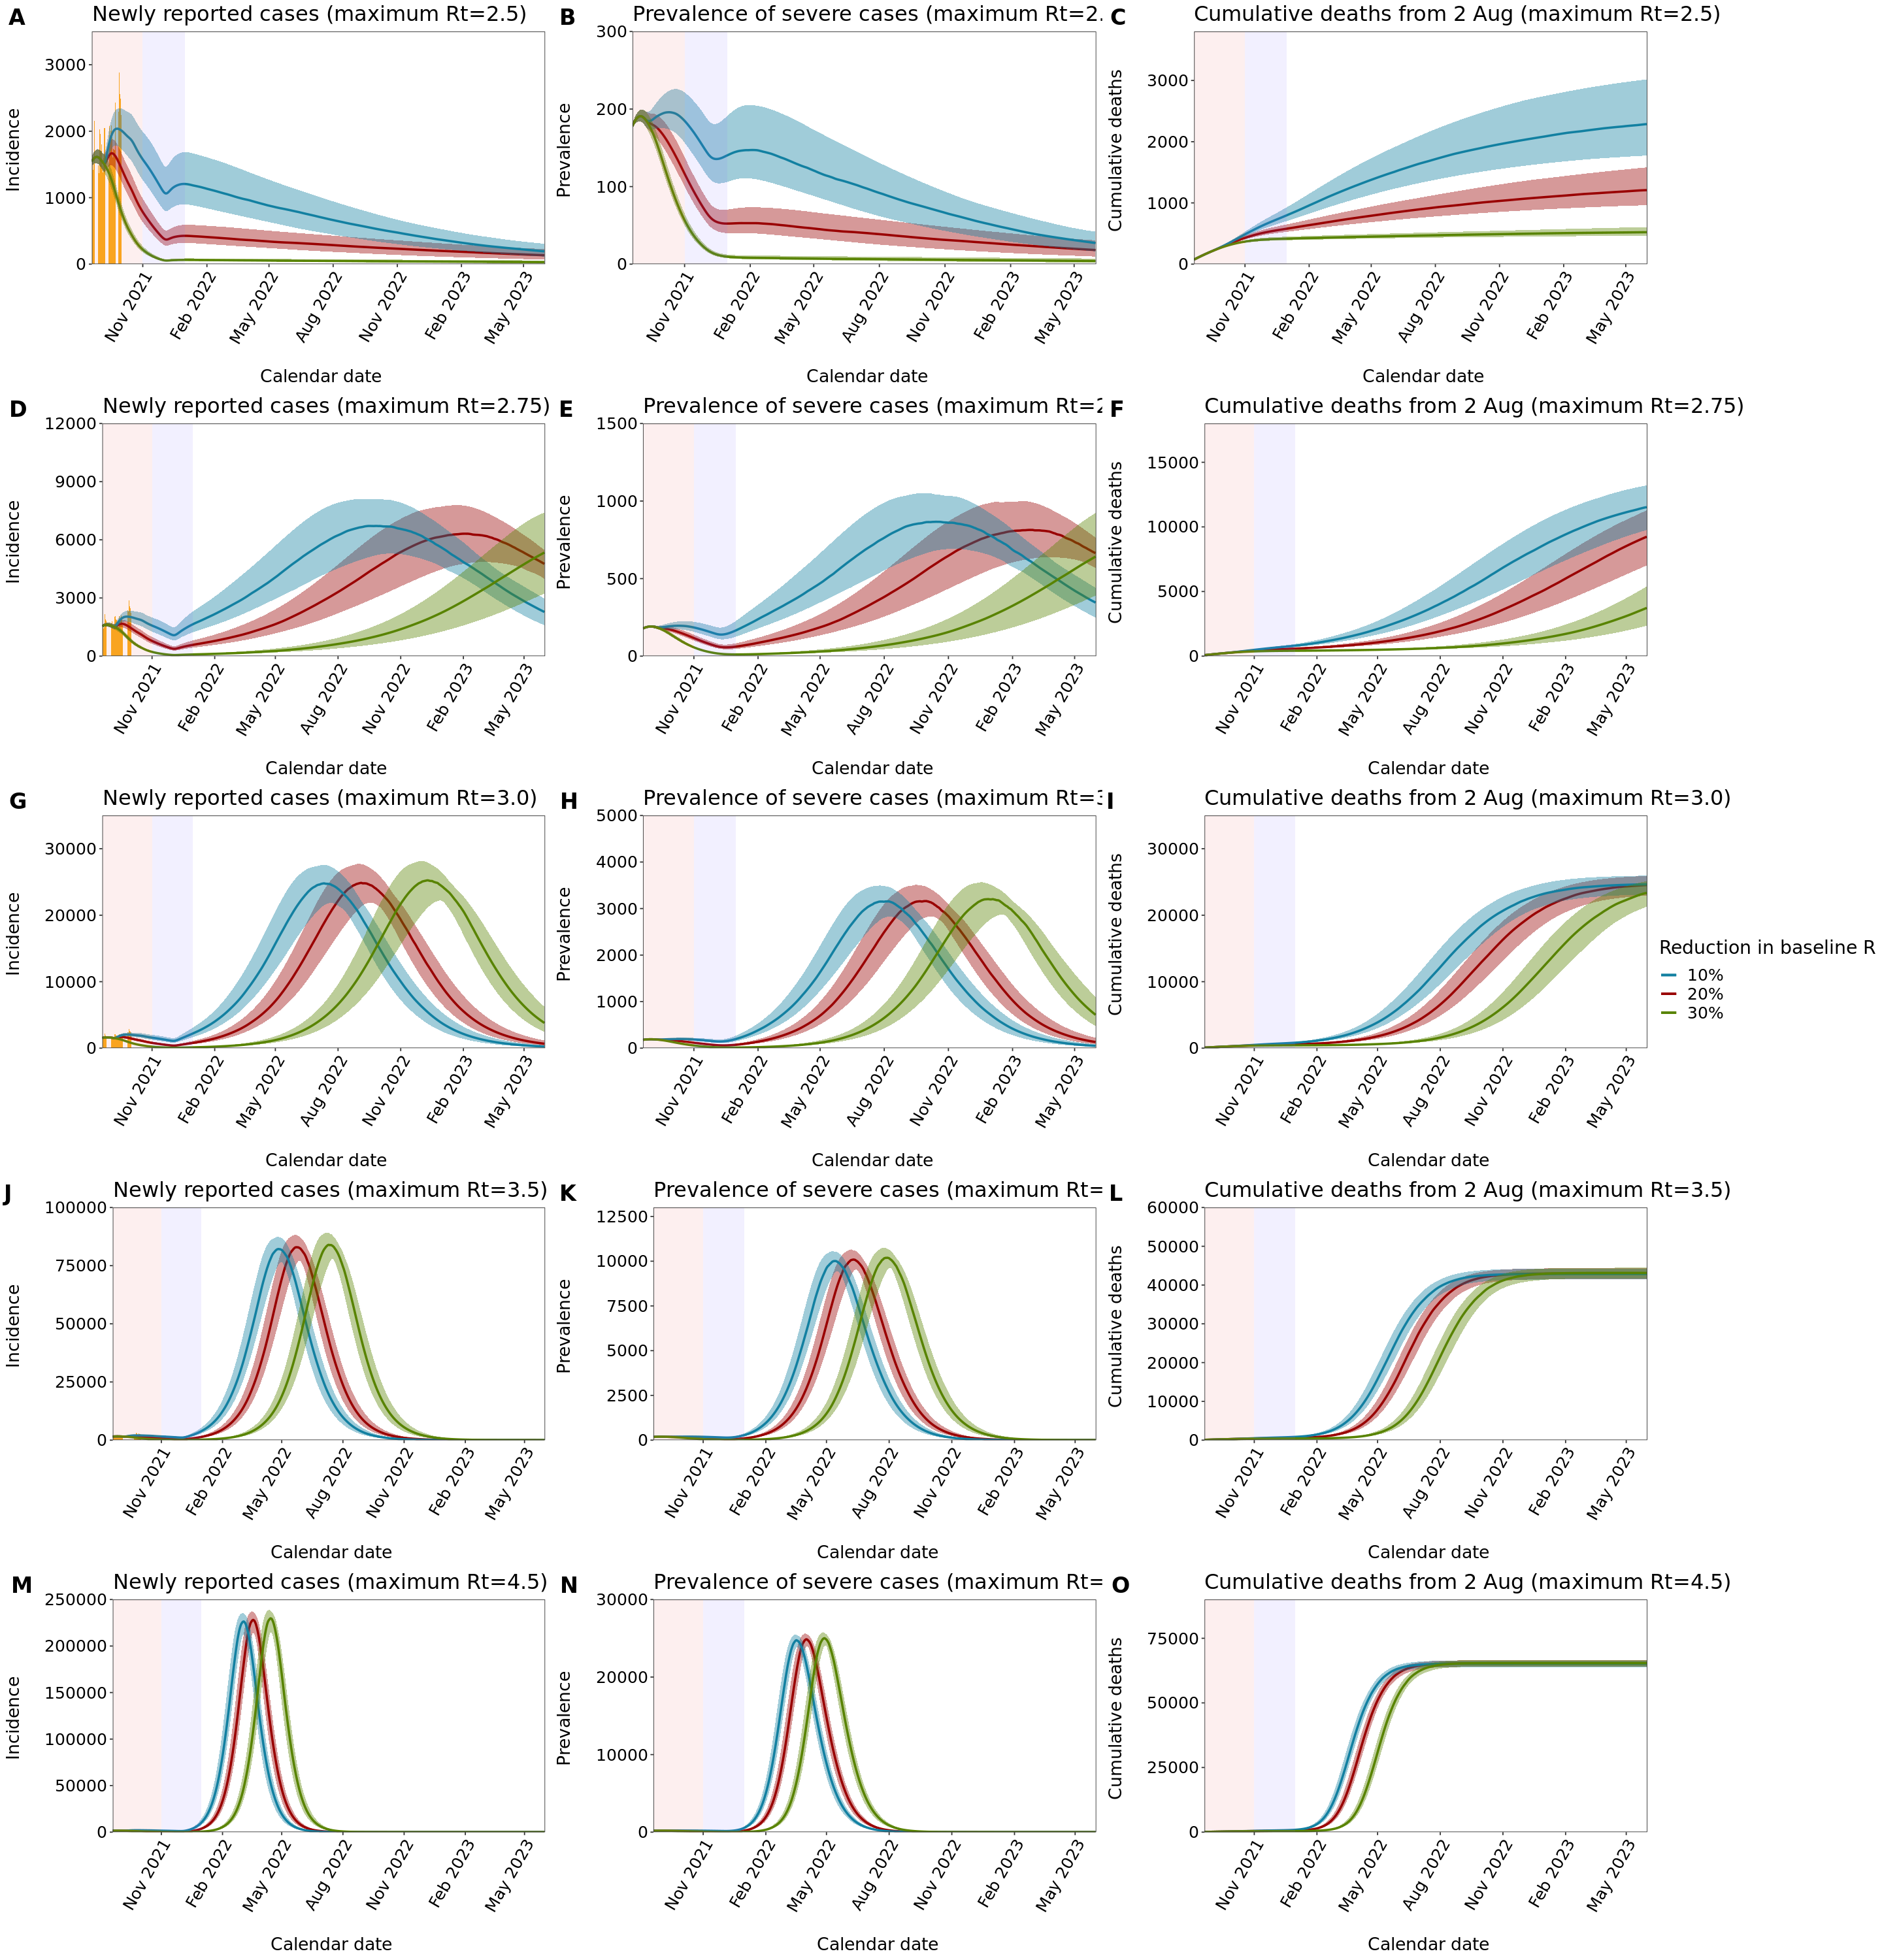

In [72]:
# options(warn = -1)
cutoff_date <- as.Date("2021-08-20")
Lift_date_figure <- Lift_date1
With_date_figure <- With_date1

options(repr.plot.width=8,repr.plot.height=5)
range_curve = c(cutoff_date, Finish_date)

ylimit1 = c(3500, 12000, 35000, 100000, 250000)
ylimit2 = c(300, 1500, 5000, 13000, 30000)
ylimit3 = c(3800, 18000, 35000, 60000, 90000)

x_days <- c("3 months")

options(warn=-1)

ggplot() + 
geom_bar(data=Korea_reported, aes(x=Date, y=reported),stat='identity', fill="#FAAB18", width=0.7) +
# geom_line(data=Korea_reported, aes(x=Date, y=MVA),color="lightslateblue", size=1.5) +

geom_line(data=final_list[[1]][[2]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="20%"), size=1) +
geom_ribbon(data=final_list[[1]][[5]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[1]][[3]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="10%"), size=1) +
geom_ribbon(data=final_list[[1]][[6]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[1]][[1]] %>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="30%"), size=1) +
geom_ribbon(data=final_list[[1]][[4]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#588300", alpha = 0.4) +

ggtitle("Newly reported cases (maximum Rt=2.5)") +
labs(x="\n Calendar date", y="Incidence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +

coord_cartesian(ylim = c(0,ylimit1[1])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig1

ggplot() + 

geom_line(data=final_list[[1]][[8]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="20%"), size=1) +
geom_ribbon(data=final_list[[1]][[11]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[1]][[9]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="10%"), size=1) +
geom_ribbon(data=final_list[[1]][[12]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[1]][[7]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="30%"), size=1) +
geom_ribbon(data=final_list[[1]][[10]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#588300", alpha = 0.4) +

ggtitle("Prevalence of severe cases (maximum Rt=2.5)") +
labs(x="\n Calendar date", y="Prevalence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit2[1])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig2

ggplot() + 

geom_line(data=final_list[[1]][[14]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="20%"), size=1) +
geom_ribbon(data=final_list[[1]][[17]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[1]][[15]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="10%"), size=1) +
geom_ribbon(data=final_list[[1]][[18]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[1]][[13]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="30%"), size=1) +
geom_ribbon(data=final_list[[1]][[16]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#588300", alpha = 0.4) +

ggtitle("Cumulative deaths from 2 Aug (maximum Rt=2.5)") +
labs(x="\n Calendar date", y="Cumulative deaths \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit3[1])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig3


####
ggplot() + 
geom_bar(data=Korea_reported, aes(x=Date, y=reported),stat='identity', fill="#FAAB18", width=0.7) +
# geom_line(data=Korea_reported, aes(x=Date, y=MVA),color="lightslateblue", size=1.5) +

geom_line(data=final_list[[2]][[2]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="20%"), size=1) +
geom_ribbon(data=final_list[[2]][[5]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[2]][[3]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="10%"), size=1) +
geom_ribbon(data=final_list[[2]][[6]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[2]][[1]] %>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="30%"), size=1) +
geom_ribbon(data=final_list[[2]][[4]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#588300", alpha = 0.4) +

ggtitle("Newly reported cases (maximum Rt=2.75)") +
labs(x="\n Calendar date", y="Incidence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +

coord_cartesian(ylim = c(0,ylimit1[2])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig4

ggplot() + 

geom_line(data=final_list[[2]][[8]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="20%"), size=1) +
geom_ribbon(data=final_list[[2]][[11]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[2]][[9]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="10%"), size=1) +
geom_ribbon(data=final_list[[2]][[12]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[2]][[7]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="30%"), size=1) +
geom_ribbon(data=final_list[[2]][[10]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#588300", alpha = 0.4) +

ggtitle("Prevalence of severe cases (maximum Rt=2.75)") +
labs(x="\n Calendar date", y="Prevalence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit2[2])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig5

ggplot() + 

geom_line(data=final_list[[2]][[14]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="20%"), size=1) +
geom_ribbon(data=final_list[[2]][[17]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[2]][[15]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="10%"), size=1) +
geom_ribbon(data=final_list[[2]][[18]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[2]][[13]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="30%"), size=1) +
geom_ribbon(data=final_list[[2]][[16]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#588300", alpha = 0.4) +

ggtitle("Cumulative deaths from 2 Aug (maximum Rt=2.75)") +
labs(x="\n Calendar date", y="Cumulative deaths \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit3[2])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig6

####
ggplot() + 
geom_bar(data=Korea_reported, aes(x=Date, y=reported),stat='identity', fill="#FAAB18", width=0.7) +
# geom_line(data=Korea_reported, aes(x=Date, y=MVA),color="lightslateblue", size=1.5) +

geom_line(data=final_list[[3]][[2]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="20%"), size=1) +
geom_ribbon(data=final_list[[3]][[5]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[3]][[3]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="10%"), size=1) +
geom_ribbon(data=final_list[[3]][[6]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[3]][[1]] %>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="30%"), size=1) +
geom_ribbon(data=final_list[[3]][[4]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#588300", alpha = 0.4) +

ggtitle("Newly reported cases (maximum Rt=3.0)") +
labs(x="\n Calendar date", y="Incidence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +

coord_cartesian(ylim = c(0,ylimit1[3])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig7

ggplot() + 

geom_line(data=final_list[[3]][[8]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="20%"), size=1) +
geom_ribbon(data=final_list[[3]][[11]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[3]][[9]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="10%"), size=1) +
geom_ribbon(data=final_list[[3]][[12]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[3]][[7]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="30%"), size=1) +
geom_ribbon(data=final_list[[3]][[10]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#588300", alpha = 0.4) +

ggtitle("Prevalence of severe cases (maximum Rt=3.0)") +
labs(x="\n Calendar date", y="Prevalence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit2[3])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig8

ggplot() + 

geom_line(data=final_list[[3]][[14]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="20%"), size=1) +
geom_ribbon(data=final_list[[3]][[17]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[3]][[15]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="10%"), size=1) +
geom_ribbon(data=final_list[[3]][[18]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[3]][[13]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="30%"), size=1) +
geom_ribbon(data=final_list[[3]][[16]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#588300", alpha = 0.4) +

ggtitle("Cumulative deaths from 2 Aug (maximum Rt=3.0)") +
labs(x="\n Calendar date", y="Cumulative deaths \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit3[3])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig9

####
ggplot() + 
geom_bar(data=Korea_reported, aes(x=Date, y=reported),stat='identity', fill="#FAAB18", width=0.7) +
# geom_line(data=Korea_reported, aes(x=Date, y=MVA),color="lightslateblue", size=1.5) +

geom_line(data=final_list[[4]][[2]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="20%"), size=1) +
geom_ribbon(data=final_list[[4]][[5]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[4]][[3]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="10%"), size=1) +
geom_ribbon(data=final_list[[4]][[6]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[4]][[1]] %>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="30%"), size=1) +
geom_ribbon(data=final_list[[4]][[4]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#588300", alpha = 0.4) +

ggtitle("Newly reported cases (maximum Rt=3.5)") +
labs(x="\n Calendar date", y="Incidence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +

coord_cartesian(ylim = c(0,ylimit1[4])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig10

ggplot() + 

geom_line(data=final_list[[4]][[8]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="20%"), size=1) +
geom_ribbon(data=final_list[[4]][[11]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[4]][[9]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="10%"), size=1) +
geom_ribbon(data=final_list[[4]][[12]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[4]][[7]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="30%"), size=1) +
geom_ribbon(data=final_list[[4]][[10]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#588300", alpha = 0.4) +

ggtitle("Prevalence of severe cases (maximum Rt=3.5)") +
labs(x="\n Calendar date", y="Prevalence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit2[4])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig11

ggplot() + 

geom_line(data=final_list[[4]][[14]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="20%"), size=1) +
geom_ribbon(data=final_list[[4]][[17]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[4]][[15]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="10%"), size=1) +
geom_ribbon(data=final_list[[4]][[18]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[4]][[13]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="30%"), size=1) +
geom_ribbon(data=final_list[[4]][[16]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#588300", alpha = 0.4) +

ggtitle("Cumulative deaths from 2 Aug (maximum Rt=3.5)") +
labs(x="\n Calendar date", y="Cumulative deaths \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit3[4])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig12

####
ggplot() + 
geom_bar(data=Korea_reported, aes(x=Date, y=reported),stat='identity', fill="#FAAB18", width=0.7) +
# geom_line(data=Korea_reported, aes(x=Date, y=MVA),color="lightslateblue", size=1.5) +

geom_line(data=final_list[[5]][[2]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="20%"), size=1) +
geom_ribbon(data=final_list[[5]][[5]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[5]][[3]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="10%"), size=1) +
geom_ribbon(data=final_list[[5]][[6]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[5]][[1]] %>% filter(date >= cutoff_date), 
          aes(x=date, y=case, colour="30%"), size=1) +
geom_ribbon(data=final_list[[5]][[4]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_case, ymin=min_case),fill="#588300", alpha = 0.4) +

ggtitle("Newly reported cases (maximum Rt=4.5)") +
labs(x="\n Calendar date", y="Incidence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +

coord_cartesian(ylim = c(0,ylimit1[5])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig13

ggplot() + 

geom_line(data=final_list[[5]][[8]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="20%"), size=1) +
geom_ribbon(data=final_list[[5]][[11]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[5]][[9]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="10%"), size=1) +
geom_ribbon(data=final_list[[5]][[12]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[5]][[7]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=severe, colour="30%"), size=1) +
geom_ribbon(data=final_list[[5]][[10]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_severe, ymin=min_severe),fill="#588300", alpha = 0.4) +

ggtitle("Prevalence of severe cases (maximum Rt=4.5)") +
labs(x="\n Calendar date", y="Prevalence \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit2[5])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig14

ggplot() + 

geom_line(data=final_list[[5]][[14]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="20%"), size=1) +
geom_ribbon(data=final_list[[5]][[17]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#990000", alpha = 0.4) +

geom_line(data=final_list[[5]][[15]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="10%"), size=1) +
geom_ribbon(data=final_list[[5]][[18]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#1380A1", alpha = 0.4) +

geom_line(data=final_list[[5]][[13]]%>% filter(date >= cutoff_date), 
          aes(x=date, y=death, colour="30%"), size=1) +
geom_ribbon(data=final_list[[5]][[16]]%>% filter(date >= cutoff_date),
            aes(x=date, ymax=max_death, ymin=min_death),fill="#588300", alpha = 0.4) +

ggtitle("Cumulative deaths from 2 Aug (maximum Rt=4.5)") +
labs(x="\n Calendar date", y="Cumulative deaths \n") +
theme(text = element_text(size=16, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
      panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      legend.title = element_text(size = 17),
      legend.text = element_text(size = 15),
      axis.text.x = element_text(angle=60, hjust=1)) +
scale_x_date(date_labels="%b %Y",date_breaks = x_days, limits = range_curve, expand = c(0, 0)) +
scale_y_continuous(expand = c(0, 0)) +
coord_cartesian(ylim = c(0,ylimit3[5])) +
annotate("rect", xmin = cutoff_date, xmax = Lift_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "indianred2") +
annotate("rect", xmin = Lift_date_figure, xmax = With_date_figure, 
         ymin = 0, ymax = 500000, alpha = 0.1, fill = "lightslateblue") +
scale_colour_manual("Reduction in baseline R",  breaks=c("10%", "20%", "30%"), 
                    values = c("10%"="#1380A1", "20%"="#990000", "30%"="#588300")) -> Fig15
library(ggpubr)
options(repr.plot.width=24,repr.plot.height=25)
ggarrange(Fig1, Fig2, Fig3, Fig4, Fig5, Fig6, Fig7, Fig8, Fig9,
          Fig10, Fig11, Fig12, Fig13, Fig14, Fig15, 
          ncol = 3, nrow = 5, labels = c("A", "B", "C", "D", "E", "F", "G", "H", "I",
                                         "J", "K", "L", "M", "N", "O"), 
          font.label = list(size = 20),
          common.legend = TRUE, legend="right")
ggsave("../figures/Korea_simulation_request4.png", width = 24, height = 25)

options(warn=0)

In [ ]:
tempp <- list()
for (g in 1:length(result_list)){
    final_list[[g]][[1]] %>% filter(date >= cutoff_date) %>% arrange(date) %>% 
    dplyr::select(date, case) -> temp1
    final_list[[g]][[4]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_case, max_case) -> temp1_CI
    final_list[[g]][[2]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(case) -> temp2
    final_list[[g]][[5]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_case, max_case) -> temp2_CI
    final_list[[g]][[3]] %>% filter(date >= cutoff_date) %>% arrange(date) %>% 
    dplyr::select(case) -> temp3
    final_list[[g]][[6]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_case, max_case) -> temp3_CI
    cbind(temp1, temp1_CI, temp2, temp2_CI, temp3, temp3_CI) -> temp_group
    colnames(temp_group) <- c("Date", "10_med", "10_min", "10_max",
                              "20_med", "20_min", "20_max",
                              "30_med", "30_min", "30_max") 
    temp_group -> tempp[[g]]
}

do.call(cbind, tempp) -> tempp
write.csv(tempp, "newly_reported_4.csv")

tempp_severe <- list()
for (g in 1:length(result_list)){
    final_list[[g]][[7]] %>% filter(date >= cutoff_date) %>% arrange(date) %>% 
    dplyr::select(date, severe) -> temp1
    final_list[[g]][[10]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_severe, max_severe) -> temp1_CI
    final_list[[g]][[8]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(severe) -> temp2
    final_list[[g]][[11]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_severe, max_severe) -> temp2_CI
    final_list[[g]][[9]] %>% filter(date >= cutoff_date) %>% arrange(date) %>% 
    dplyr::select(severe) -> temp3
    final_list[[g]][[12]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_severe, max_severe) -> temp3_CI
    cbind(temp1, temp1_CI, temp2, temp2_CI, temp3, temp3_CI) -> temp_group
    colnames(temp_group) <- c("Date", "10_med", "10_min", "10_max",
                              "20_med", "20_min", "20_max",
                              "30_med", "30_min", "30_max")  
    temp_group -> tempp_severe[[g]]
}

do.call(cbind, tempp_severe) -> tempp_severe
write.csv(tempp_severe, "prevalence_severe_4.csv")

tempp_death <- list()
for (g in 1:length(result_list)){
    final_list[[g]][[13]] %>% filter(date >= cutoff_date) %>% arrange(date) %>% 
    dplyr::select(date, death) -> temp1
    final_list[[g]][[16]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_death, max_death) -> temp1_CI
    final_list[[g]][[14]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(death) -> temp2
    final_list[[g]][[17]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_death, max_death) -> temp2_CI
    final_list[[g]][[15]] %>% filter(date >= cutoff_date) %>% arrange(date) %>% 
    dplyr::select(death) -> temp3
    final_list[[g]][[18]] %>% filter(date >= cutoff_date) %>% arrange(date) %>%
    dplyr::select(min_death, max_death) -> temp3_CI
    cbind(temp1, temp1_CI, temp2, temp2_CI, temp3, temp3_CI) -> temp_group
    colnames(temp_group) <- c("Date", "10_med", "10_min", "10_max",
                              "20_med", "20_min", "20_max",
                              "30_med", "30_min", "30_max") 
    temp_group -> tempp_death[[g]]
}

do.call(cbind, tempp_death) -> tempp_death
write.csv(tempp_death, "cumulative_death_4.csv")

In [ ]:
final_list[[1]][1] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_25

final_list[[2]][1] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_275

final_list[[3]][1] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_30

final_list[[4]][1] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_35

final_list[[5]][1] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

cbind(Reduction_Rt_25, Reduction_Rt_275[,-1], Reduction_Rt_30[,-1], 
      Reduction_Rt_35[,-1], Reduction_Rt_45[,-1]) -> temp
colnames(temp) <- c("Date", "25_group1", "25_group2", "25_group3", "25_group4",
                    "275_group1", "275_group2", "275_group3", "275_group4",
                    "30_group1", "30_group2", "30_group3", "30_group4",
                    "35_group1", "35_group2", "35_group3", "35_group4",                            
                    "45_group1", "45_group2", "45_group3", "45_group4") 
write.csv(temp, "Reduction_10_request4.csv")

final_list[[1]][2] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_25

final_list[[2]][2] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_35

final_list[[3]][2] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

final_list[[4]][2] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

final_list[[5]][2] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

cbind(Reduction_Rt_25, Reduction_Rt_275[,-1], Reduction_Rt_30[,-1], 
      Reduction_Rt_35[,-1], Reduction_Rt_45[,-1]) -> temp
colnames(temp) <- c("Date", "25_group1", "25_group2", "25_group3", "25_group4",
                    "275_group1", "275_group2", "275_group3", "275_group4",
                    "30_group1", "30_group2", "30_group3", "30_group4",
                    "35_group1", "35_group2", "35_group3", "35_group4",                            
                    "45_group1", "45_group2", "45_group3", "45_group4") 
write.csv(temp, "Reduction_20_request4.csv")

final_list[[1]][3] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_25

final_list[[2]][3] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_35

final_list[[3]][3] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

final_list[[4]][3] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

final_list[[5]][3] %>% as.data.frame() %>% dplyr::select(date, V1, V2, V3, V4) %>% 
mutate(V1=round(V1), V2=round(V2), V3=round(V3), V4=round(V4)) -> Reduction_Rt_45

cbind(Reduction_Rt_25, Reduction_Rt_275[,-1], Reduction_Rt_30[,-1], 
      Reduction_Rt_35[,-1], Reduction_Rt_45[,-1]) -> temp
colnames(temp) <- c("Date", "25_group1", "25_group2", "25_group3", "25_group4",
                    "275_group1", "275_group2", "275_group3", "275_group4",
                    "30_group1", "30_group2", "30_group3", "30_group4",
                    "35_group1", "35_group2", "35_group3", "35_group4",                            
                    "45_group1", "45_group2", "45_group3", "45_group4") 
write.csv(temp, "Reduction_30_request4.csv")